# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: [MooseML/homo-lumo-gap-models](https://github.com/MooseML/homo-lumo-gap-models)


In [1]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [3]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [4]:
# /path/to/your_script.py
import os
import pandas as pd


train_path = os.path.join(DATA_ROOT, 'train.csv')
train_df   = pd.read_csv(train_path)

#  Keep only the columns we care about 
target_cols = ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_df   = train_df[target_cols]        # drops id and any other columns

#  Sample a subset (optional) 
n = len(train_df)
subset_size = n                         # change to whatever you need
subset_df = train_df.sample(subset_size, random_state=42)

#  Save the subset as a CSV 
subset_path = os.path.join(DATA_ROOT, 'train_subset.csv')
subset_df.to_csv(subset_path, index=False)

print(f"Saved CSV with shape: {subset_df.shape}")
print(subset_df.head())

Saved CSV with shape: (7973, 6)
                                                 SMILES  Tg       FFV  \
7560  *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC... NaN  0.386695   
1405                  *CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1 NaN  0.335504   
5196                              *CC(*)c1ccccc1C(=O)NC NaN  0.355580   
2087  *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-... NaN  0.401573   
3337                    *CC(*)OC(=O)c1ccc(-c2ccccc2)cc1 NaN  0.353609   

            Tc  Density  Rg  
7560       NaN      NaN NaN  
1405       NaN      NaN NaN  
5196  0.183667      NaN NaN  
2087       NaN      NaN NaN  
3337       NaN      NaN NaN  


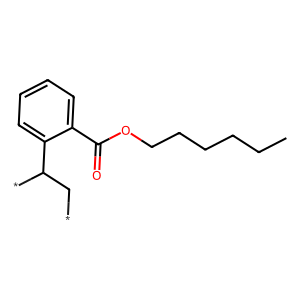

In [5]:
mol = Molecule(subset_df['SMILES'][0], input_type='smiles')
mol.visualize()

In [6]:
df = pd.read_csv(subset_path)
print(f"Loaded {len(df)} molecules.")

Loaded 7973 molecules.


In [7]:
df.head(5)

,SMILES,Tg,FFV,Tc,Density,Rg
0,*C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC...,NaN,0.386695,NaN,NaN,NaN
1,*CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1,NaN,0.335504,NaN,NaN,NaN
2,*CC(*)c1ccccc1C(=O)NC,NaN,0.355580,0.183667,NaN,NaN
3,*c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-...,NaN,0.401573,NaN,NaN,NaN
4,*CC(*)OC(=O)c1ccc(-c2ccccc2)cc1,NaN,0.353609,NaN,NaN,NaN


In [8]:
missing_values = df.isnull().sum()
total_rows = len(df)
percent_missing = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': percent_missing
})

print("Missing Values by Column:")
print(missing_df)
print("\nFeature Statistics (Min, Max, Mean, etc.):")
print(df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].describe())

Missing Values by Column:
         Total Missing  Percent Missing
SMILES               0         0.000000
Tg                7462        93.590869
FFV                943        11.827418
Tc                7236        90.756303
Density           7360        92.311551
Rg                7359        92.299009

Feature Statistics (Min, Max, Mean, etc.):
               Tg          FFV          Tc     Density          Rg
count  511.000000  7030.000000  737.000000  613.000000  614.000000
mean    96.452314     0.367212    0.256334    0.985484   16.419787
std    111.228279     0.029609    0.089538    0.146189    4.608640
min   -148.029738     0.226992    0.046500    0.748691    9.728355
25%     13.674509     0.349549    0.186000    0.890243   12.540328
50%     74.040183     0.364264    0.236000    0.948193   15.052194
75%    161.147595     0.380790    0.330500    1.062096   20.411067
max    472.250000     0.777097    0.524000    1.840999   34.672906


The only property that appears will succeed with a simple imputation strategy is FFV. All other properties contain very high percent missing. Therefore, I will impute median for FFV, train a model for FFV, and train separate models for other properties. I will attempt to filter out missing values for each property. If this yields uncessful, I may explore sampling techniques or use the trained model to impute values to train a secondaery model. |

# Density Model

In [9]:
# 1. Create a new DataFrame with only the SMILES and Density columns
df_Density = df[['SMILES', 'Density']].copy()

print("Initial Density DataFrame shape:", df_Density.shape)
print("Initial Density Missing Values:")
print(df_Density.isnull().sum())

# 2. Drop all rows where the 'Density' value is missing
df_Density.dropna(subset=['Density'], inplace=True)

print("\nCleaned Density DataFrame shape:", df_Density.shape)
print("Cleaned Density Missing Values:")
print(df_Density.isnull().sum())

Initial Density DataFrame shape: (7973, 2)
Initial Density Missing Values:
SMILES        0
Density    7360
dtype: int64

Cleaned Density DataFrame shape: (613, 2)
Cleaned Density Missing Values:
SMILES     0
Density    0
dtype: int64


In [10]:
from rdkit.Chem import AllChem, Descriptors, HybridizationType, SanitizeFlags
def rdkit_ogb_agree(smi: str) -> bool:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return False
    return m.GetNumAtoms() == smiles2graph(smi)["num_nodes"]

def canonicalize_polymer_smiles(smiles: str, cap_atomic_num: int = 6) -> str:
    """
    Turn every '*' (dummy atom) into a real atom (default C) in the RDKit graph,
    preserving existing bond orders/stereo; sanitize, remove explicit Hs, and
    return canonical isomeric SMILES.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if mol is None:
        raise ValueError(f"RDKit could not parse SMILES: {smiles}")

    rw = Chem.RWMol(mol)
    for a in rw.GetAtoms():
        if a.GetAtomicNum() == 0:   # '*'
            a.SetAtomicNum(cap_atomic_num)  # 6 = carbon
            a.SetFormalCharge(0)
            a.SetIsAromatic(False)
            a.SetNoImplicit(False)
            a.SetNumExplicitHs(0)

    mol2 = rw.GetMol()
    try:
        Chem.SanitizeMol(mol2)
    except Exception:
        Chem.SanitizeMol(mol2, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        Chem.Kekulize(mol2, clearAromaticFlags=True)

    mol2 = Chem.RemoveHs(mol2)
    return Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [11]:
# Build the molecule list
valid_mol_objs = []
valid_targets = []  # Now stores an array with one value per molecule

for i, row in df_Density.iterrows():
    smi = row['SMILES']
    
    # 2.a Clean the SMILES first
    cleaned_smiles = canonicalize_polymer_smiles(smi)

    try:
        # 2.b Create your custom Molecule from the cleaned string
        mol = Molecule(cleaned_smiles, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)

        # 2.c Only keep molecules that got a 3-D geometry
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            
            # Keep only the 'Tc' target column as a NumPy array
            valid_targets.append(
                row[['Density']].values
            )
        else:
            print(f"Skipped bc missing xyz: {smi}")

    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

print(f"Kept {len(valid_mol_objs)} molecules after filtering.")

df_clean = pd.DataFrame({
    'SMILES': [m.smiles for m in valid_mol_objs],
    'Density': [t[0] for t in valid_targets],
})
print(f"Kept {len(df_clean)} molecules after filtering.")
df_clean.to_csv('cleaned_Density_dataset.csv', index=False)
print("Saved cleaned Density dataset to 'cleaned_Density_dataset.csv'.")

y = np.array([t[0] for t in valid_targets])
print("Target shape:", y.shape)

# Your feature computation will now work correctly
fp_featurizer = RDKitFingerprint(
    fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3
)
X_fp = fp_featurizer.represent(valid_mol_objs)

print("RDKit FP shape:", X_fp.shape)

Failed on */C=C/CCCCCCCCCC(CCCCCCCCC*)COCCOCCOCCOCCOCCCCCC | Reason: Bad Conformer Id
Kept 612 molecules after filtering.
Kept 612 molecules after filtering.
Saved cleaned Density dataset to 'cleaned_Density_dataset.csv'.
Target shape: (612,)
RDKit FP shape: (612, 1024)


In [12]:
# # 1. make separate train/test splits for both scaled and unscaled targets
# # scaled targets (MLP, KRR, GNN)
# X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(
#     X_fp, y, test_size=0.2, random_state=42
# )
# # X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(
# #     X_cm, y, test_size=0.2, random_state=42
# # )

# xscaler_fp = StandardScaler()
# # xscaler_cm = StandardScaler()
# yscaler = StandardScaler()

# X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
# X_test_fp_scaled  = xscaler_fp.transform(X_test_fp_scaled)

# # X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
# # X_test_cm_scaled  = xscaler_cm.transform(X_test_cm_scaled)

# y_train_scaled = yscaler.fit_transform(y_train_scaled)
# y_test_scaled  = yscaler.transform(y_test_scaled)

# # b) unscaled targets (Random Forest)
# y_unscaled = y              
# X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
#     X_fp, y_unscaled, test_size=0.2, random_state=42
# )

# # 2. show shapes
# tools.display_dataframe_to_user(
#     name="Cleaned Feature Splits",
#     dataframe=pd.DataFrame({
#         "Split": [
#             "X_train_fp_scaled", "X_test_fp_scaled",
#             # "X_train_cm_scaled", "X_test_cm_scaled",
#             "y_train_scaled",   "y_test_scaled",
#             "X_train_fp_unscaled", "X_test_fp_unscaled",
#             "y_train_unscaled",   "y_test_unscaled"
#         ],
#         "Shape": [
#             X_train_fp_scaled.shape, X_test_fp_scaled.shape,
#             # X_train_cm_scaled.shape, X_test_cm_scaled.shape,
#             y_train_scaled.shape,   y_test_scaled.shape,
#             X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
#             y_train_unscaled.shape,   y_test_unscaled.shape
#         ]
#     })
# )

# 1. make separate train/test splits for both scaled and unscaled targets
# a) Scaled targets (for KRR)
# Your y is now a 1D array of FFV values.
X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    X_fp, y, test_size=0.2, random_state=42
)

xscaler_fp = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp)

# Reshape y arrays for the StandardScaler
y_train_scaled = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = yscaler.transform(y_test.reshape(-1, 1))

# b) Unscaled targets (for models that don't need scaling, like Random Forest)
# These are the original, unscaled splits. You can use the variables you already created.
X_train_fp_unscaled = X_train_fp
X_test_fp_unscaled = X_test_fp
y_train_unscaled = y_train
y_test_unscaled = y_test

# 2. show shapes
# The shape display now reflects the single target variable
tools.display_dataframe_to_user(
    name="Cleaned Feature Splits",
    dataframe=pd.DataFrame({
        "Split": [
            "X_train_fp_scaled", "X_test_fp_scaled",
            "y_train_scaled", "y_test_scaled",
            "X_train_fp_unscaled", "X_test_fp_unscaled",
            "y_train_unscaled", "y_test_unscaled"
        ],
        "Shape": [
            X_train_fp_scaled.shape, X_test_fp_scaled.shape,
            y_train_scaled.shape, y_test_scaled.shape,
            X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
            y_train_unscaled.shape, y_test_unscaled.shape
        ]
    })
)

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [13]:
# Kernel Ridge on RDKit fingerprints
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)

# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled)

# Inverse transform predictions and test targets to compare with unscaled values
# You must reshape y_pred_krr_scaled and y_test_scaled to 2D before inverse transforming
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled.reshape(-1, 1)).flatten()
y_test_krr = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.079649  0.127916   0.278361


## Random Forest Regression baseline 

In [14]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.059141  0.097546   0.580347


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [15]:
# MLP (Fingerprint)
mlp_fp = MLP(
    engine='tensorflow',
    nfeatures=X_train_fp_scaled.shape[1],
    nneurons=[64, 128], # These are the hidden layers
    activations=['ReLU', 'ReLU'],
    learning_rate=0.01,
    alpha=0.001,
    nepochs=200,
    batch_size=64,
    loss='mean_squared_error',
    is_regression=True
)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled.ravel()) # Use .ravel() to convert to 1D
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled)
# Reshape the output from predict() to 2D before inverse transforming
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled.reshape(-1, 1)).flatten()
y_test_fp = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("MLP (RDKit FP)")
metrics_mlp = regression_metrics(y_test, y_pred_fp)
print(metrics_mlp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
8/8 [==============================] - 0s 2ms/step - loss: 1.3476
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 0.6983
Epoch 3/200
8/8 [==============================] - 0s 2ms/step - loss: 0.4612
Epoch 4/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3483
Epoch 5/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2876
Epoch 6/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2549
Epoch 7/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2393
Epoch 8/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2229
Epoch 9/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2156
Epoch 10/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2108
Epoch 11/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2080
Epoch 12/200
8/8 [==============================] - 0s 2ms/step - loss: 0.2066
Epoch 13/200
8/8 [==============================] - 0s 2ms/st

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [16]:
# # MLP (Coulomb matrix)
# mlp_cm = MLP(
#     engine='tensorflow', 
#     nfeatures=X_train_cm_scaled.shape[1], 
#     nneurons=[64, 128], 
#     activations=['ReLU', 'ReLU'],
#     learning_rate=0.0001, 
#     alpha=0.001, 
#     nepochs=100, 
#     batch_size=64, 
#     loss='mean_squared_error', 
#     is_regression=True
#     )

# mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
# y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled)
# y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
# y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [17]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
        #    "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)
        }

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.079649  0.127916   0.278361

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.059141  0.097546   0.580347

MLP (RDKit FP)
        MAE      RMSE  r_squared
0  0.078087  0.128295   0.274082


## Parity Plots and Residuals Histograms

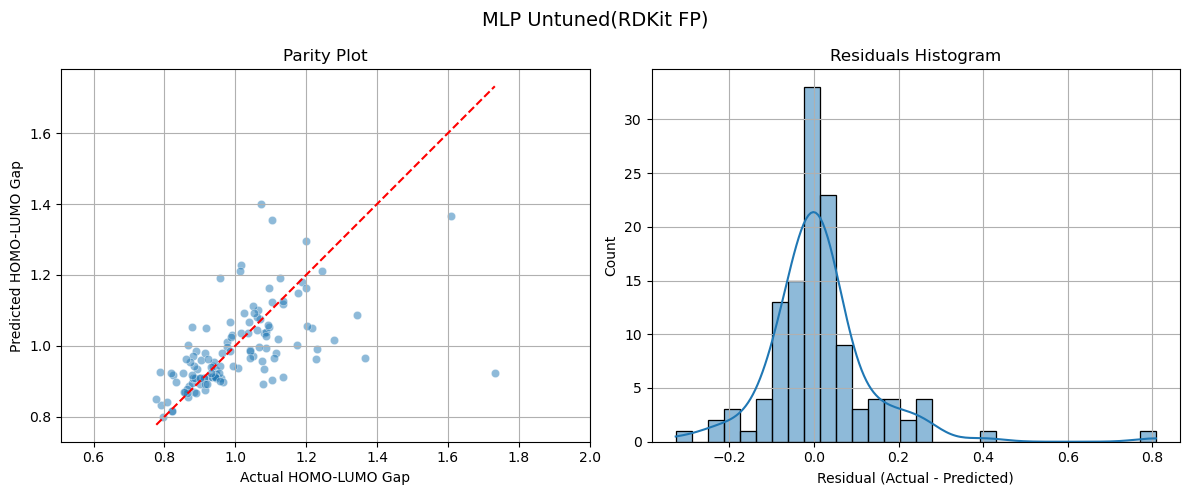

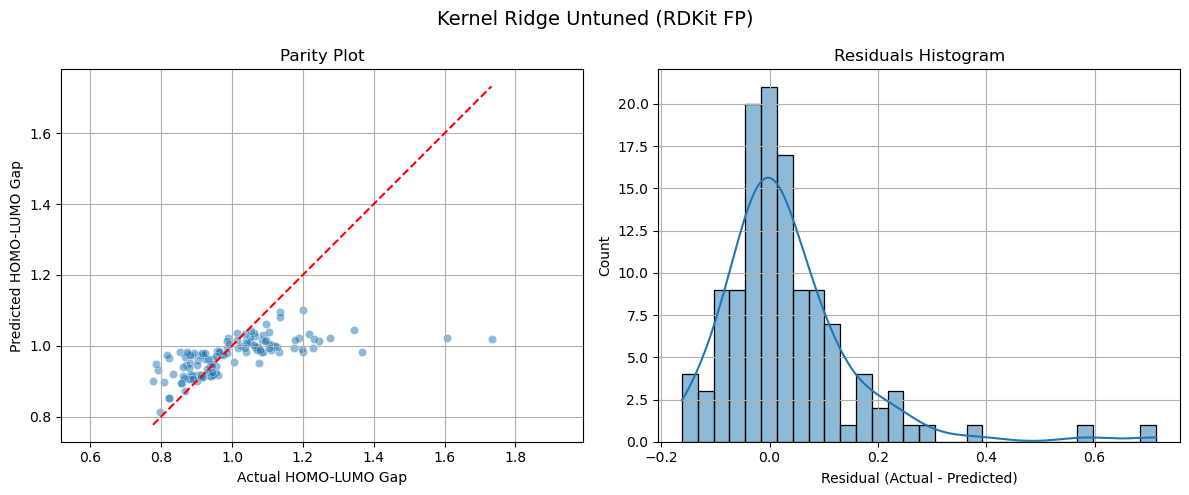

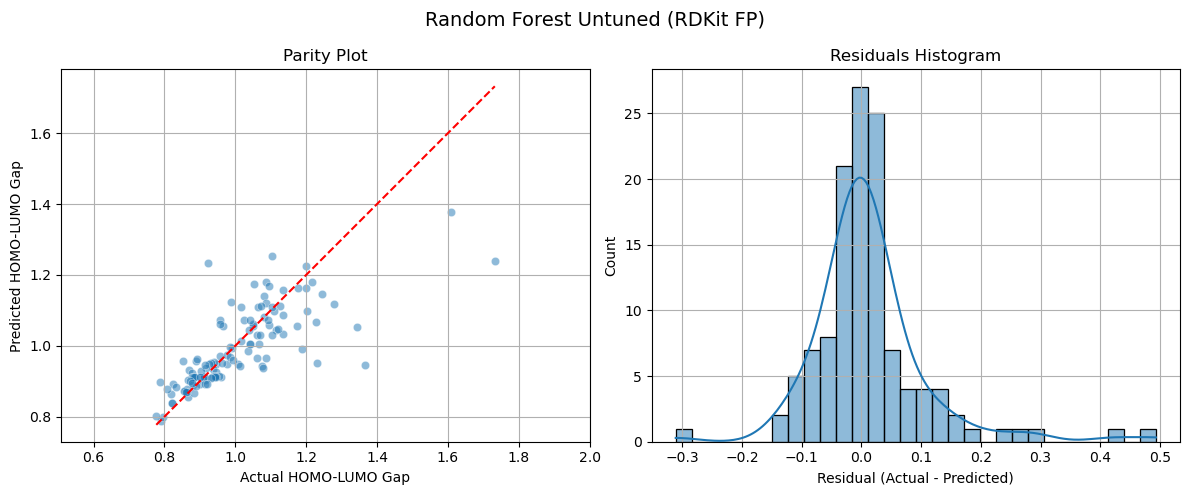

In [18]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
# plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [70]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=1000)

[I 2025-09-04 20:39:38,400] A new study created in memory with name: no-name-fa37560e-29da-4c89-8155-ed105387bf29
[I 2025-09-04 20:39:38,420] Trial 0 finished with value: 0.05905954906906582 and parameters: {'alpha': 0.03139550425170362, 'kernel': 'rbf', 'gamma': 0.00029668678294808733}. Best is trial 0 with value: 0.05905954906906582.
[I 2025-09-04 20:39:38,448] Trial 1 finished with value: 0.09635586103536026 and parameters: {'alpha': 0.28545732356322556, 'kernel': 'rbf', 'gamma': 0.1364400330138878}. Best is trial 0 with value: 0.05905954906906582.
[I 2025-09-04 20:39:38,460] Trial 2 finished with value: 0.07211680527642089 and parameters: {'alpha': 0.05832389871741109, 'kernel': 'linear'}. Best is trial 0 with value: 0.05905954906906582.
[I 2025-09-04 20:39:38,474] Trial 3 finished with value: 0.06336756315409528 and parameters: {'alpha': 0.3750366857168329, 'kernel': 'poly'}. Best is trial 0 with value: 0.05905954906906582.
[I 2025-09-04 20:39:38,488] Trial 4 finished with value: 

In [71]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 100, step=10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=100)

[I 2025-09-04 20:40:04,863] A new study created in memory with name: no-name-bd3930b0-e3a7-4261-8953-181b4c3650f3
[I 2025-09-04 20:40:05,554] Trial 0 finished with value: 0.057099426960056 and parameters: {'n_estimators': 300, 'max_depth': 60}. Best is trial 0 with value: 0.057099426960056.
[I 2025-09-04 20:40:05,929] Trial 1 finished with value: 0.057391817593805 and parameters: {'n_estimators': 150, 'max_depth': 40}. Best is trial 0 with value: 0.057099426960056.
[I 2025-09-04 20:40:06,301] Trial 2 finished with value: 0.057418177683146866 and parameters: {'n_estimators': 150, 'max_depth': 100}. Best is trial 0 with value: 0.057099426960056.
[I 2025-09-04 20:40:06,766] Trial 3 finished with value: 0.05755569138863197 and parameters: {'n_estimators': 200, 'max_depth': 80}. Best is trial 0 with value: 0.057099426960056.
[I 2025-09-04 20:40:07,247] Trial 4 finished with value: 0.057555691388631945 and parameters: {'n_estimators': 200, 'max_depth': 60}. Best is trial 0 with value: 0.0570

In [72]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(
        engine='tensorflow',
        nfeatures=X_train_fp_scaled.shape[1], 
        nneurons=[n1, n2],
        activations=[act, act], 
        learning_rate=lr, 
        alpha=alpha,
        nepochs=100, 
        batch_size=64, 
        loss='mean_squared_error', 
        is_regression=True
        )
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

[I 2025-09-04 20:41:01,799] A new study created in memory with name: no-name-35c2e65c-7c82-48dd-9b9d-d51a99c47cfe


Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 22.9201
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 21.7562
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 20.6927
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 19.8147
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 18.9141
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 18.0293
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 17.2271
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 16.4463
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 15.7161
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 15.0168
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 14.3528
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7192
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:41:04,067] Trial 0 finished with value: 0.057319972964435854 and parameters: {'lr': 0.004877790875291095, 'alpha': 0.02822341765299844, 'activation': 'gelu', 'n1': 320, 'n2': 256}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 18.8482
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 17.3314
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 16.0161
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 14.7160
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 13.4730
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3272
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 11.2627
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2861
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3932
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5797
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8356
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1562
Epoch 13/100
8/8 [==============================] - 0

[I 2025-09-04 20:41:06,132] Trial 1 finished with value: 0.06684448399550375 and parameters: {'lr': 0.0084545893288932, 'alpha': 0.03183034883250811, 'activation': 'tanh', 'n1': 192, 'n2': 320}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2643
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7082
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5242
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.4090
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3527
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3376
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2989
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2857
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2777
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2708
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2684
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2664
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:08,445] Trial 2 finished with value: 0.07792147221133992 and parameters: {'lr': 0.00960511010876708, 'alpha': 0.0006437813360416931, 'activation': 'gelu', 'n1': 128, 'n2': 320}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4142
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3792
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3273
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3275
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3040
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2956
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2876
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2742
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2656
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2548
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 3.2457
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2356
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:10,531] Trial 3 finished with value: 0.0744519459555143 and parameters: {'lr': 0.00048648214750788475, 'alpha': 0.004513789558403411, 'activation': 'sigmoid', 'n1': 192, 'n2': 192}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7371
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2575
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3779
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9690
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7473
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6237
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5420
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4923
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4621
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.4343
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 3.4090
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3879
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:12,683] Trial 4 finished with value: 0.06762757181148099 and parameters: {'lr': 0.004406483034048912, 'alpha': 0.0037959621246850717, 'activation': 'gelu', 'n1': 384, 'n2': 384}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.8224
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.4511
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.5718
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1037
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.6499
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2368
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8951
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5534
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2364
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 8.9340
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 8.6455
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3692
Epoch 13/100
8/8 [==============================] - 0s 

[I 2025-09-04 20:41:14,870] Trial 5 finished with value: 0.05797942669422008 and parameters: {'lr': 0.0030303526983152607, 'alpha': 0.03268877062416736, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 30.4605
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 30.0314
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 29.6524
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 29.3482
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 29.0939
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 28.8732
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 28.6734
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 28.4909
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 28.3219
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 28.1562
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 28.0016
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 27.8518
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:41:16,903] Trial 6 finished with value: 0.07645716588027954 and parameters: {'lr': 0.00027885729650323795, 'alpha': 0.04956144139996848, 'activation': 'tanh', 'n1': 256, 'n2': 128}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7930
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0474
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6907
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5212
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4267
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3572
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3271
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3047
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2893
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2768
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 2.2658
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2557
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:18,860] Trial 7 finished with value: 0.0693364063225234 and parameters: {'lr': 0.004401425385975549, 'alpha': 0.002694561533336286, 'activation': 'relu', 'n1': 384, 'n2': 256}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 17.6520
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.7360
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 16.1617
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 15.6738
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 15.2297
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 14.8051
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 14.3997
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 14.0105
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 13.6347
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 13.2697
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 12.9155
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 12.5716
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:41:20,832] Trial 8 finished with value: 0.06904305810589204 and parameters: {'lr': 0.0027291617676879626, 'alpha': 0.030406699466489818, 'activation': 'tanh', 'n1': 192, 'n2': 256}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7015
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6510
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6534
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6595
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6539
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6522
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6008
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6347
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5811
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5868
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5646
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5356
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:23,204] Trial 9 finished with value: 0.06671265661277435 and parameters: {'lr': 0.0014108849246159767, 'alpha': 0.0015450454276534605, 'activation': 'sigmoid', 'n1': 128, 'n2': 384}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9657
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3140
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2452
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1353
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9916
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9138
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8420
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7843
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7371
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6963
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6601
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6290
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:25,234] Trial 10 finished with value: 0.11273588803402286 and parameters: {'lr': 0.00010145977284004536, 'alpha': 0.00014598531220437567, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 0 with value: 0.057319972964435854.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2273
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0548
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5041
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1497
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4721
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0586
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6606
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2425
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8797
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.5558
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2458
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9511
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:27,402] Trial 11 finished with value: 0.05547902615405149 and parameters: {'lr': 0.018051709807701197, 'alpha': 0.011552448789854505, 'activation': 'gelu', 'n1': 320, 'n2': 128}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3019
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8092
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1883
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9348
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6429
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2709
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9341
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6388
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3407
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1064
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8908
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6898
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:29,562] Trial 12 finished with value: 0.056346990448554325 and parameters: {'lr': 0.019278335797070882, 'alpha': 0.008335447122207115, 'activation': 'gelu', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3640
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5214
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9886
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5867
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2166
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8308
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3715
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0506
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7458
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4656
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 4.1823
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9120
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:31,724] Trial 13 finished with value: 0.05600377163807145 and parameters: {'lr': 0.01911402976859831, 'alpha': 0.009499817606537855, 'activation': 'gelu', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1571
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1600
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4586
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8976
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4227
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9966
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6064
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2402
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 4.9106
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5855
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2903
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0149
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:33,861] Trial 14 finished with value: 0.056183686271671945 and parameters: {'lr': 0.015021198134866057, 'alpha': 0.013348770550644016, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3098
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7432
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4440
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2714
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1585
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0723
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0005
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 7.9334
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8773
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8264
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7771
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7301
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:36,051] Trial 15 finished with value: 0.06821395156289774 and parameters: {'lr': 0.001525004912217897, 'alpha': 0.011219144719064772, 'activation': 'gelu', 'n1': 320, 'n2': 192}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0903
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5785
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2583
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0470
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9432
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9104
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8833
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8686
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.8627
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8551
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8508
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8470
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:38,211] Trial 16 finished with value: 0.0651536565700056 and parameters: {'lr': 0.009542354171222216, 'alpha': 0.0011594531064714711, 'activation': 'gelu', 'n1': 384, 'n2': 128}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4819
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3273
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1169
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8512
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7638
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 4.6067
Epoch 7/100
8/8 [==============================] - 0s 1ms/step - loss: 4.4099
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 4.0651
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9195
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7836
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6241
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4933
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:40,202] Trial 17 finished with value: 0.06760958412065136 and parameters: {'lr': 0.012494060019632434, 'alpha': 0.00717179762673171, 'activation': 'sigmoid', 'n1': 256, 'n2': 192}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8663
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1414
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.7859
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6248
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5233
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4676
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4296
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4025
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3830
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3676
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3553
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3472
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:42,116] Trial 18 finished with value: 0.09350567137933398 and parameters: {'lr': 0.0009130542633948031, 'alpha': 0.0004569866025834408, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6558
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7752
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1562
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6829
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2454
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8738
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5160
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2007
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 7.9049
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 7.6170
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3432
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0818
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 20:41:44,345] Trial 19 finished with value: 0.057671045421119754 and parameters: {'lr': 0.006805341051596448, 'alpha': 0.016324252416942124, 'activation': 'gelu', 'n1': 256, 'n2': 192}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8230
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1219
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3610
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0494
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7692
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5668
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3535
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1693
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0086
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8559
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7211
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5907
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:46,471] Trial 20 finished with value: 0.058103405822556166 and parameters: {'lr': 0.01904207578983886, 'alpha': 0.005639708540910874, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3209
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5814
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9986
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6083
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6702
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1010
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6071
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1610
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7731
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3982
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 4.0631
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7549
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:48,608] Trial 21 finished with value: 0.05553921104892539 and parameters: {'lr': 0.016972100836890127, 'alpha': 0.014055782639925728, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 11 with value: 0.05547902615405149.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.9690
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3057
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7386
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9338
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2160
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6357
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0876
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5866
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 6.1516
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7276
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3434
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9848
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 20:41:50,765] Trial 22 finished with value: 0.05522516988470013 and parameters: {'lr': 0.012098726697002295, 'alpha': 0.017135528059547874, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1912
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3035
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8672
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4920
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1748
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8657
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 6.6069
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 6.3585
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 6.1250
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 5.9031
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6897
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4852
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:53,036] Trial 23 finished with value: 0.05549001086043841 and parameters: {'lr': 0.006738311596913693, 'alpha': 0.016669335798345626, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8374
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2642
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4590
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9272
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5033
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.1044
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 7.7160
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 7.3894
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0773
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7762
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4958
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2276
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 20:41:55,224] Trial 24 finished with value: 0.055628261978950315 and parameters: {'lr': 0.006430559554092802, 'alpha': 0.019995536093243168, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1885
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3636
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.5472
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.6426
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9662
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 7.3402
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 6.7747
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2544
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7756
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3345
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9286
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5544
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 20:41:57,457] Trial 25 finished with value: 0.05534934469101845 and parameters: {'lr': 0.011165755111217692, 'alpha': 0.021286745241515158, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8218
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3821
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8842
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6318
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4988
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4089
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3701
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3393
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 1.3180
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2975
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2799
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2646
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:41:59,482] Trial 26 finished with value: 0.06568620584279229 and parameters: {'lr': 0.012843139831163258, 'alpha': 0.0028857260788679334, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 34.0098
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 32.6554
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 31.3007
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 29.9382
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 28.6032
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 27.3042
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 26.0374
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 24.8586
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 23.6556
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 22.5245
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 21.4712
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 20.4555
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:42:01,473] Trial 27 finished with value: 0.06451724102875103 and parameters: {'lr': 0.003133668038567194, 'alpha': 0.046884533215032526, 'activation': 'sigmoid', 'n1': 256, 'n2': 320}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7839
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7237
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.7604
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8922
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1327
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.4412
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8148
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2106
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6655
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1438
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6679
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 6.2228
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 20:42:03,638] Trial 28 finished with value: 0.05561883193994413 and parameters: {'lr': 0.010413061503495002, 'alpha': 0.01994605475747065, 'activation': 'gelu', 'n1': 256, 'n2': 192}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6931
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 4.8543
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5298
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3647
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2836
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 4.2229
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1879
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1583
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1352
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.1143
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0961
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0795
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:05,536] Trial 29 finished with value: 0.07637144673670301 and parameters: {'lr': 0.0017280921632592252, 'alpha': 0.006277628230581563, 'activation': 'tanh', 'n1': 320, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.2984
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2220
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 13.5340
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 12.9015
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3474
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8303
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3401
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8746
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 10.4357
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0159
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 9.6143
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 9.2298
Epoch 13/100
8/8 [==============================] -

[I 2025-09-04 20:42:07,913] Trial 30 finished with value: 0.056534391803872694 and parameters: {'lr': 0.005186002727426944, 'alpha': 0.024102812387169516, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8448
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0301
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4305
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.1230
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8726
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6641
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4852
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3116
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1479
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.9910
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 4.8394
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6934
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:10,114] Trial 31 finished with value: 0.05855825515793865 and parameters: {'lr': 0.007063698898109019, 'alpha': 0.013334077658426683, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 22 with value: 0.05522516988470013.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.8458
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2189
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7088
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1805
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8784
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7089
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6616
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7458
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9413
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2338
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6101
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 4.0636
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 20:42:12,247] Trial 32 finished with value: 0.05518764075470691 and parameters: {'lr': 0.012107618787005664, 'alpha': 0.03067918887300317, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.1065
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.4386
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.8610
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2798
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8990
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6651
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6036
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6849
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8989
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.2183
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6355
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1353
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 20:42:14,509] Trial 33 finished with value: 0.057609918224864685 and parameters: {'lr': 0.011729426166760013, 'alpha': 0.03693864415430173, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.1010
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.9151
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.7796
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6366
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.6656
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 9.7623
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 8.9358
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 8.1760
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4863
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8549
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2780
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7504
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 20:42:16,717] Trial 34 finished with value: 0.05603895463295268 and parameters: {'lr': 0.008950457723489805, 'alpha': 0.029410861479852977, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.0487
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.6787
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3599
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1095
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9099
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8295
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8590
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9903
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2191
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5327
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9213
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 4.3796
Epoch 13/100
8/8 [==============================] - 0s 2m

[I 2025-09-04 20:42:18,764] Trial 35 finished with value: 0.0656919740235174 and parameters: {'lr': 0.013541449990146212, 'alpha': 0.02520889539025953, 'activation': 'tanh', 'n1': 192, 'n2': 320}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4656
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7500
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4576
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3138
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2257
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1271
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0584
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9985
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9545
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9064
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8651
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8241
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:21,002] Trial 36 finished with value: 0.07235197785478199 and parameters: {'lr': 0.004819418946458425, 'alpha': 0.008435851713799744, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8014
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0285
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8499
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6508
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5360
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4798
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4397
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4109
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3851
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3649
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3472
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 1.3293
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 20:42:23,294] Trial 37 finished with value: 0.0628955408834628 and parameters: {'lr': 0.008561279098752065, 'alpha': 0.004180832865277652, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 20.4506
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 20.1561
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 19.9291
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 19.7816
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 19.6075
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 19.4583
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 19.3078
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 19.1586
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 19.0116
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 18.8646
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 18.7195
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 18.5749
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:42:25,389] Trial 38 finished with value: 0.06977250144145958 and parameters: {'lr': 0.0006001444035070143, 'alpha': 0.040017016458923346, 'activation': 'sigmoid', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.6854
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 14.7968
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.2124
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7992
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 13.4183
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 13.0432
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6975
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3644
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 12.0429
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 11.7300
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 11.4279
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 11.1354
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:42:27,576] Trial 39 finished with value: 0.0607990513917735 and parameters: {'lr': 0.0038247440090365173, 'alpha': 0.020907420853573794, 'activation': 'gelu', 'n1': 256, 'n2': 320}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 27.0039
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 26.6761
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 26.3442
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 26.0763
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 25.8510
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 25.6472
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 25.4643
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 25.2988
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 25.1449
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 24.9953
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 24.8542
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 24.7179
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:42:29,558] Trial 40 finished with value: 0.08208854229502335 and parameters: {'lr': 0.0002777275783221874, 'alpha': 0.049424588808173055, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6595
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8188
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4877
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2693
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1081
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9626
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8313
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7062
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5945
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4836
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 4.3786
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2763
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:33,501] Trial 41 finished with value: 0.06366946494195778 and parameters: {'lr': 0.006313558960098299, 'alpha': 0.011384352576415737, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 8.7060
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 7.7617
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 7.0695
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 6.5512
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 6.0063
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 5.5384
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 5.1094
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 4.7142
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 4.3551
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 4.0253
Epoch 11/100
8/8 [==============================] - 0s 6ms/step - loss: 3.7207
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 3.4411
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 20:42:37,786] Trial 42 finished with value: 0.05531580437327117 and parameters: {'lr': 0.014964798968675502, 'alpha': 0.01566908231243299, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 12.2426
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 10.8114
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 9.4478
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 8.1542
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 7.0416
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 6.0682
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 5.2258
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 4.4924
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 3.8628
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3250
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8640
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 2.4685
Epoch 13/100
8/8 [==============================] - 0s 4ms/

[I 2025-09-04 20:42:41,782] Trial 43 finished with value: 0.057664988693649166 and parameters: {'lr': 0.0140535624412374, 'alpha': 0.03100437995278481, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8289
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3595
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 3.0961
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8213
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6561
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 2.5865
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 2.4994
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 2.4283
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3768
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 2.3247
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2777
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 2.2337
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 20:42:44,286] Trial 44 finished with value: 0.06250732468456957 and parameters: {'lr': 0.010478157091749263, 'alpha': 0.005597480485467518, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 12.1176
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.4763
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2691
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 9.1988
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3369
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6202
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8975
Epoch 8/100
8/8 [==============================] - 0s 1ms/step - loss: 6.2669
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6936
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1783
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7112
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2866
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 20:42:46,202] Trial 45 finished with value: 0.056806152920519076 and parameters: {'lr': 0.01603294210899753, 'alpha': 0.01749026346949877, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0697
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4975
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 5.2769
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7924
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5460
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3113
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1266
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9564
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7942
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6424
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5022
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3677
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:48,421] Trial 46 finished with value: 0.05803855959278833 and parameters: {'lr': 0.011497016735602154, 'alpha': 0.010383084889548796, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 21.2942
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 19.7792
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 18.4773
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 16.9966
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 15.7592
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 14.6159
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 13.5594
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 12.5747
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6559
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8151
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0366
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 9.3129
Epoch 13/100
8/8 [==============================] 

[I 2025-09-04 20:42:50,532] Trial 47 finished with value: 0.056605389060111935 and parameters: {'lr': 0.008483154851299766, 'alpha': 0.026457663384538744, 'activation': 'gelu', 'n1': 384, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6703
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8623
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6253
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5009
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4269
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3730
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3432
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3181
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3005
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 1.2887
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2790
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2701
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:52,796] Trial 48 finished with value: 0.07951956115635321 and parameters: {'lr': 0.0024638615698234336, 'alpha': 0.003369886367474081, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1446
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0121
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8456
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6370
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6406
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5243
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4133
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3091
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2863
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2497
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2088
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1882
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:54,782] Trial 49 finished with value: 0.06614580712585029 and parameters: {'lr': 0.01583576313869056, 'alpha': 0.00019931365454135995, 'activation': 'sigmoid', 'n1': 256, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8595
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1472
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 2.2638
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9755
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6552
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6452
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6630
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5319
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4819
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4501
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4270
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4042
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:56,969] Trial 50 finished with value: 0.06294333004979726 and parameters: {'lr': 0.019727794891622328, 'alpha': 0.00210581836046524, 'activation': 'gelu', 'n1': 320, 'n2': 192}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0891
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 8.3578
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7731
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2797
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9118
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 6.5801
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2979
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0272
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7690
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5270
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2948
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0740
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:42:59,124] Trial 51 finished with value: 0.056828731511729416 and parameters: {'lr': 0.007956505766443066, 'alpha': 0.01638923145698071, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4269
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6107
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3299
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0492
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8567
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6765
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 5.5365
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3997
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2742
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1510
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0333
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9193
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:01,319] Trial 52 finished with value: 0.0576547042442746 and parameters: {'lr': 0.0054116367977517415, 'alpha': 0.013017865927377316, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 32 with value: 0.05518764075470691.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 18.3280
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.6037
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 14.9801
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.0542
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.4308
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 10.0185
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 8.7685
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 7.6586
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6963
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.8561
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1249
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4840
Epoch 13/100
8/8 [==============================] - 0s 

[I 2025-09-04 20:43:03,469] Trial 53 finished with value: 0.05475905187032859 and parameters: {'lr': 0.010756591901560204, 'alpha': 0.03634904765097859, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 20.1308
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 18.0951
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 15.7982
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 13.4146
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 11.2960
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 9.4792
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 7.9560
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6693
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5978
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6867
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9321
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2998
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 20:43:05,692] Trial 54 finished with value: 0.058284122235405904 and parameters: {'lr': 0.014906825652794225, 'alpha': 0.033604099218263205, 'activation': 'gelu', 'n1': 192, 'n2': 384}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 15.0176
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7016
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6907
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 11.5462
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 10.6060
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 9.7492
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9819
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2688
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6278
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 7.0226
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4721
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9655
Epoch 13/100
8/8 [==============================] - 0s 1

[I 2025-09-04 20:43:07,711] Trial 55 finished with value: 0.057533966678384924 and parameters: {'lr': 0.010477553195878455, 'alpha': 0.023254404668709792, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 20.3558
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 20.1654
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 19.9908
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 19.8463
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 19.7210
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 19.6086
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 19.5024
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 19.4115
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 19.3302
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 19.2543
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 19.1882
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 19.1247
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:43:09,858] Trial 56 finished with value: 0.08886248809934413 and parameters: {'lr': 0.00010673213834710723, 'alpha': 0.03928454721527949, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0962
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2422
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9430
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7304
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5375
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3728
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 4.2157
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0703
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9303
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7959
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6675
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5437
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:11,950] Trial 57 finished with value: 0.0688618574042887 and parameters: {'lr': 0.012280287562953069, 'alpha': 0.008558695464712687, 'activation': 'tanh', 'n1': 256, 'n2': 128}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 21.4798
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 20.4233
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 19.5693
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 18.9153
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 18.2512
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 17.6250
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 17.0250
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 16.4552
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 15.9043
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 15.3732
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 14.8604
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 14.3657
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:43:14,101] Trial 58 finished with value: 0.05689272440419912 and parameters: {'lr': 0.003704978372962356, 'alpha': 0.028079304233979252, 'activation': 'gelu', 'n1': 320, 'n2': 192}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4350
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9834
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2806
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.8641
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5516
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4533
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3514
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3212
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3083
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2850
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2799
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2750
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:16,308] Trial 59 finished with value: 0.06866629215159993 and parameters: {'lr': 0.016962093542961198, 'alpha': 0.0007623582973198823, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 16.9700
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 16.3040
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 15.6100
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 14.9438
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 14.3150
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 13.7645
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 13.2852
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 12.8283
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 12.3978
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 11.9816
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 11.5810
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 11.1948
Epoch 13/100
8/8 [==============================]

[I 2025-09-04 20:43:18,454] Trial 60 finished with value: 0.0571366080250465 and parameters: {'lr': 0.005675881179066727, 'alpha': 0.018337733410551386, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8677
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9895
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.5573
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1501
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8413
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 6.5554
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 6.2884
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0345
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7971
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5677
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3483
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1398
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:20,614] Trial 61 finished with value: 0.055707064862350344 and parameters: {'lr': 0.0075256447307874294, 'alpha': 0.01621480633707514, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 53 with value: 0.05475905187032859.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9802
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3764
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7607
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2793
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9327
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6314
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3717
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1174
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 4.8822
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.6581
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4470
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2450
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:22,819] Trial 62 finished with value: 0.05460859024789379 and parameters: {'lr': 0.009991733390915645, 'alpha': 0.014140758961254614, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 62 with value: 0.05460859024789379.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4799
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0467
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3416
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5935
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6669
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3314
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0374
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8029
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 3.5469
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.2820
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0622
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8189
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:24,966] Trial 63 finished with value: 0.053822076321526996 and parameters: {'lr': 0.01993684431732709, 'alpha': 0.011095672720080682, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8213
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4165
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9719
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6079
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4290
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2976
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2213
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1218
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0424
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9610
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8895
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8177
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 20:43:27,110] Trial 64 finished with value: 0.05929108827374665 and parameters: {'lr': 0.009820468971457394, 'alpha': 0.007462757909519325, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8172
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1795
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6078
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0715
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6761
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3275
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0180
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7256
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4517
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 4.1936
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9508
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7249
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:29,309] Trial 65 finished with value: 0.05487145463454282 and parameters: {'lr': 0.012715244667094843, 'alpha': 0.014001307944183578, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8492
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.2869
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.7587
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3202
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7765
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4337
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0047
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6669
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 4.3750
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0984
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8462
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6155
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:31,257] Trial 66 finished with value: 0.06518618047121474 and parameters: {'lr': 0.013507061378047384, 'alpha': 0.013372536267493636, 'activation': 'sigmoid', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5462
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7384
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.2210
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7967
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4173
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1478
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8389
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 3.5920
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3556
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1388
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9386
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7519
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:33,413] Trial 67 finished with value: 0.055199169886022796 and parameters: {'lr': 0.01810333148714392, 'alpha': 0.010922474520992138, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5376
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1833
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8167
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9310
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 2.4525
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3070
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1894
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1126
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0352
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 1.9682
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 1.8904
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8306
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:35,376] Trial 68 finished with value: 0.05557632165406539 and parameters: {'lr': 0.01997808327660462, 'alpha': 0.004996412344082573, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0283
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1889
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7834
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4483
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 4.2893
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 4.1326
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9950
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8732
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7596
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6517
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5497
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4507
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:37,543] Trial 69 finished with value: 0.05740487349223638 and parameters: {'lr': 0.009047517265502849, 'alpha': 0.009566082919073361, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6504
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0872
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6677
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5220
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3449
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2143
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1350
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0256
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 1.9483
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 1.8646
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7916
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7273
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:39,802] Trial 70 finished with value: 0.05488869648500222 and parameters: {'lr': 0.01718844462427971, 'alpha': 0.0064055346993602096, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6609
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1055
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6499
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3218
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9647
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 3.6607
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3922
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1548
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9521
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7520
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5889
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4104
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:42,032] Trial 71 finished with value: 0.058359816933880065 and parameters: {'lr': 0.017235047984952092, 'alpha': 0.011462293326619341, 'activation': 'gelu', 'n1': 128, 'n2': 256}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9935
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4250
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1175
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9367
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 2.7595
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6377
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5248
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4347
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3517
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2735
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1993
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1285
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:44,240] Trial 72 finished with value: 0.05474919088194461 and parameters: {'lr': 0.012847910997248111, 'alpha': 0.007694977047038544, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4599
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8986
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5648
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3670
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2492
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1557
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 2.0829
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 2.0142
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9545
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8856
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8248
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7725
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

[I 2025-09-04 20:43:46,801] Trial 73 finished with value: 0.05647860545887 and parameters: {'lr': 0.014023071236793366, 'alpha': 0.0061133698831931545, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1915
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6873
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2870
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0198
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8164
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6771
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 2.5499
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 2.4327
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3273
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2256
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1283
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0369
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:49,067] Trial 74 finished with value: 0.0563925415728916 and parameters: {'lr': 0.01685175177302209, 'alpha': 0.007760090481085906, 'activation': 'gelu', 'n1': 128, 'n2': 256}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5911
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0656
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9091
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6540
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5030
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4229
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 1.3712
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3347
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3101
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2849
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2640
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2437
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:51,256] Trial 75 finished with value: 0.05852016412439586 and parameters: {'lr': 0.012095317790254339, 'alpha': 0.0037996069087465876, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6928
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0579
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8551
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6395
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 2.5306
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4593
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3901
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3287
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2753
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2220
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1716
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1235
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:53,512] Trial 76 finished with value: 0.060328999742326944 and parameters: {'lr': 0.009825374068658731, 'alpha': 0.0069226034416431615, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8605
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3355
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0786
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 1.9443
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8398
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7564
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6883
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6331
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5824
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5356
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4922
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4509
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:55,480] Trial 77 finished with value: 0.06679994599955687 and parameters: {'lr': 0.01796959152099184, 'alpha': 0.004695157215739158, 'activation': 'tanh', 'n1': 128, 'n2': 256}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6910
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0937
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 3.7956
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 3.5953
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4850
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3583
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2563
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1654
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0866
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0093
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9382
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8685
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:43:57,773] Trial 78 finished with value: 0.05694564272546188 and parameters: {'lr': 0.007671864003610336, 'alpha': 0.009551370435513705, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 21.0904
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 18.7368
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 16.0252
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 13.3576
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 11.0206
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 9.0712
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4336
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0851
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9829
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0787
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3416
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7414
Epoch 13/100
8/8 [==============================] - 0s 2

[I 2025-09-04 20:43:59,887] Trial 79 finished with value: 0.058038208465993744 and parameters: {'lr': 0.01321291132592293, 'alpha': 0.04268927431438743, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 11.9382
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.4224
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 11.0343
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8080
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 10.6413
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 10.4940
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3694
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 10.2540
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1498
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0491
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9529
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 9.8617
Epoch 13/100
8/8 [==============================] -

[I 2025-09-04 20:44:02,074] Trial 80 finished with value: 0.07746424957837036 and parameters: {'lr': 0.0011523160916014092, 'alpha': 0.022363199238463305, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 7.1850
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6779
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0490
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5653
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 5.2445
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 4.9578
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7302
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.4952
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.2932
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0881
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9013
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7238
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:04,205] Trial 81 finished with value: 0.056177185581519656 and parameters: {'lr': 0.011355609875757584, 'alpha': 0.012400132408399659, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2196
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9847
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4693
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0961
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6120
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3397
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 4.0461
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8229
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6256
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4450
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2601
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0904
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:06,364] Trial 82 finished with value: 0.05668004780894508 and parameters: {'lr': 0.014779038422908364, 'alpha': 0.01064435352948081, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.0732
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1270
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5183
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9244
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4276
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9653
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5360
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 6.1394
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7676
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.4191
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0920
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7856
Epoch 13/100
8/8 [==============================] - 0s 2ms/s

[I 2025-09-04 20:44:08,500] Trial 83 finished with value: 0.05585919765176963 and parameters: {'lr': 0.012187924839083354, 'alpha': 0.01543416221739016, 'activation': 'gelu', 'n1': 256, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 13.4929
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3488
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2961
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6000
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0870
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8338
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8257
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9833
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3830
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 1.9024
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 1.5165
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2176
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 20:44:10,584] Trial 84 finished with value: 0.05667997216195407 and parameters: {'lr': 0.019956686030228227, 'alpha': 0.0339647214067838, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7213
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7823
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2521
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.8286
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4281
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 8.0770
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7463
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 7.4328
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 7.1348
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 6.8494
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5766
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3159
Epoch 13/100
8/8 [==============================] - 0s 2ms/s

[I 2025-09-04 20:44:12,785] Trial 85 finished with value: 0.05517210236345295 and parameters: {'lr': 0.006235125845380462, 'alpha': 0.0199153778603272, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.7849
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 10.3221
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.7957
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1882
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 8.5247
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.9552
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 7.3877
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8948
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3992
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9521
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 5.5374
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1693
Epoch 13/100
8/8 [==============================] - 0s 2ms/

[I 2025-09-04 20:44:14,826] Trial 86 finished with value: 0.06544882880008901 and parameters: {'lr': 0.009876487596184636, 'alpha': 0.020548543908096684, 'activation': 'sigmoid', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 14.1942
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 13.1752
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 12.3510
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 11.6417
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 10.9692
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 10.3432
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 9.7669
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 9.2250
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 8.7164
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 8.2362
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 7.7838
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3569
Epoch 13/100
8/8 [==============================] - 0s 

[I 2025-09-04 20:44:16,974] Trial 87 finished with value: 0.05711733827421633 and parameters: {'lr': 0.006278864444998614, 'alpha': 0.027392939459242104, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4972
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 7.6467
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3002
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8785
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5690
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 6.2924
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0349
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.7828
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5560
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3407
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1360
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.9397
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:19,133] Trial 88 finished with value: 0.05765751944930683 and parameters: {'lr': 0.008365134409331206, 'alpha': 0.014212054431657498, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 5.9254
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.1287
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.5901
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1841
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9516
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7452
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5659
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3995
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2430
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0948
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 2.9539
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8208
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:21,051] Trial 89 finished with value: 0.05637848968848253 and parameters: {'lr': 0.015286817099195299, 'alpha': 0.009184289937185364, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6636
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7538
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.5022
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3155
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0625
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 2.9081
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 2.7910
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6549
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5556
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4468
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3510
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2597
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:23,259] Trial 90 finished with value: 0.055100402914065975 and parameters: {'lr': 0.017143136172858137, 'alpha': 0.006919962418653463, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3269
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.7122
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4699
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3429
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2129
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 1.1385
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0983
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0586
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0491
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0552
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0378
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0133
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:25,407] Trial 91 finished with value: 0.0610348990489564 and parameters: {'lr': 0.017442381879667075, 'alpha': 0.0022656991730056046, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.0643
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4706
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0776
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8691
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 2.7227
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6341
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5461
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4589
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3979
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3425
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2903
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2414
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:27,596] Trial 92 finished with value: 0.05772841010911746 and parameters: {'lr': 0.010936700295080051, 'alpha': 0.00572372407794711, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0646
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.1328
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7470
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 3.3940
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2392
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1404
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9970
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8852
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7943
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7032
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.6229
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5444
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:29,757] Trial 93 finished with value: 0.05510657022282199 and parameters: {'lr': 0.012846219719139209, 'alpha': 0.007158819353537873, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7634
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1880
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0571
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7533
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5652
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4887
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3614
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2486
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.1669
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.0895
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 2.0182
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 1.9528
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:32,019] Trial 94 finished with value: 0.05978984607644704 and parameters: {'lr': 0.013156578466907388, 'alpha': 0.007569801396515614, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 4.3549
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 3.9981
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.7523
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 3.3518
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1910
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 3.0806
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9959
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 2.9174
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8550
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7941
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7384
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 2.6843
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:34,255] Trial 95 finished with value: 0.05939636379258318 and parameters: {'lr': 0.008872475754899408, 'alpha': 0.006823119221955203, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 12.6958
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 11.3748
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 10.1682
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.9792
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8975
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 6.9239
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.0613
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 5.3036
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6396
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 4.0577
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 3.5503
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 3.1072
Epoch 13/100
8/8 [==============================] - 0s 2ms

[I 2025-09-04 20:44:36,201] Trial 96 finished with value: 0.06490212924009914 and parameters: {'lr': 0.015638161335178334, 'alpha': 0.02481071238325815, 'activation': 'tanh', 'n1': 192, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 10.8509
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 9.9028
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 9.1522
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 8.4546
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 7.8694
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 7.3275
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 6.8357
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 6.3845
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 5.9612
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 5.5676
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 5.2012
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8593
Epoch 13/100
8/8 [==============================] - 0s 2ms/s

[I 2025-09-04 20:44:38,432] Trial 97 finished with value: 0.05557131357165032 and parameters: {'lr': 0.010961470487959013, 'alpha': 0.018745693800995066, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 2.3621
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6563
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4365
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3059
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2383
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1953
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1685
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 1.1522
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 1.1425
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1344
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1284
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1235
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:40,713] Trial 98 finished with value: 0.07349255440267002 and parameters: {'lr': 0.0023710896466139263, 'alpha': 0.0031774420580674544, 'activation': 'gelu', 'n1': 128, 'n2': 128}. Best is trial 63 with value: 0.053822076321526996.


Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 3.4984
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2.8898
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 2.7034
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5501
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4387
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 2.3994
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 2.3466
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 2.3084
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2742
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2472
Epoch 11/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2241
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 2.2025
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

[I 2025-09-04 20:44:42,904] Trial 99 finished with value: 0.07027183009479776 and parameters: {'lr': 0.006935437675827816, 'alpha': 0.0041549538296007296, 'activation': 'gelu', 'n1': 192, 'n2': 384}. Best is trial 63 with value: 0.053822076321526996.


In [74]:
# def objective_mlp_cm(trial):
#     lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
#     alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
#     act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
#     n1 = trial.suggest_int('n1', 64, 256, step=64)
#     n2 = trial.suggest_int('n2', 64, 256, step=64)

#     model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
#                 activations=[act, act], learning_rate=lr, alpha=alpha,
#                 nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

#     model.fit(X_train_cm_scaled, y_train_scaled)
#     preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
#     preds = yscaler.inverse_transform(preds_scaled)
#     y_test_inv = yscaler.inverse_transform(y_test_scaled)
#     metrics = regression_metrics(y_test_inv, preds)
#     return metrics['MAE'][0]

# study_mlp_cm = optuna.create_study(direction='minimize')
# study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [75]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
        MAE      RMSE  r_squared
0  0.058749  0.089094   0.557462


In [76]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
        MAE      RMSE  r_squared
0  0.056854  0.085089   0.596355


In [77]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(
    engine='tensorflow', 
    nfeatures=X_train_fp_scaled.shape[1], 
    nneurons=[best_fp['n1'], best_fp['n2']], 
    activations=[best_fp['activation'], best_fp['activation']], 
    learning_rate=best_fp['lr'], 
    alpha=best_fp['alpha'], 
    nepochs=100, 
    batch_size=64, 
    loss='mean_squared_error', 
    is_regression=True
    )

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/100
8/8 [==============================] - 0s 4ms/step - loss: 6.3291
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 5.9320
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 5.2949
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 4.9047
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 4.4490
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 4.1338
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 3.7956
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 3.5173
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 3.2638
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.0363
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 2.8287
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 2.6182
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

In [78]:
# best_cm = study_mlp_cm.best_params
# final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# # train on scaled data
# final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# # predict and inverse transform
# final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
# final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
# y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# # eval in eV
# final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
# print("Final Tuned MLP (Coulomb Matrix):")
# print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

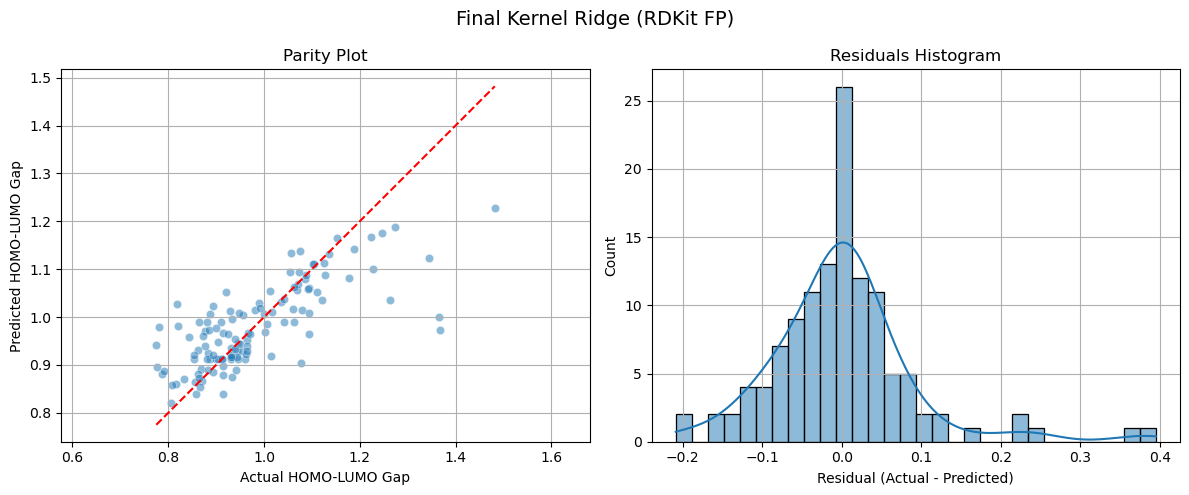

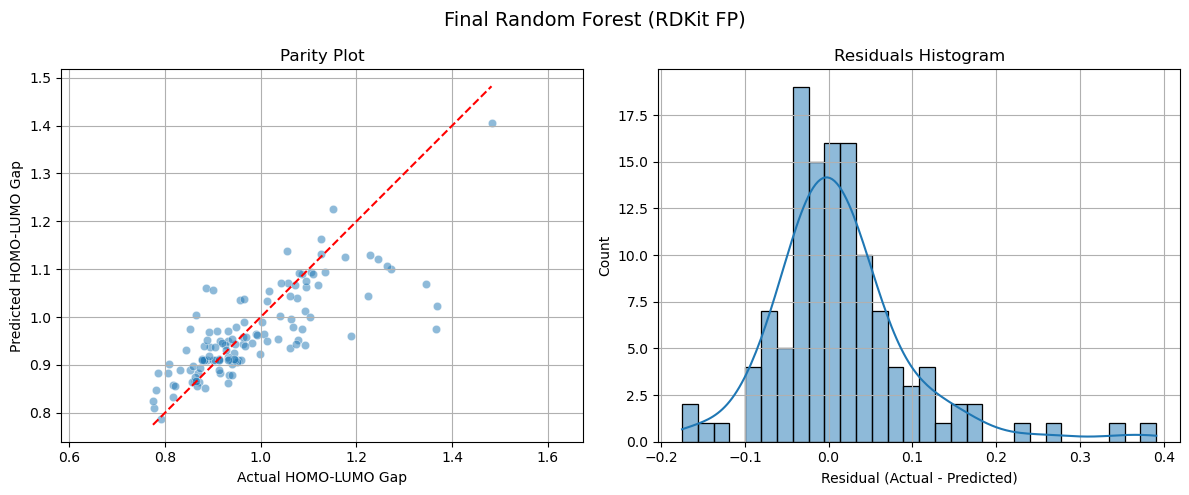

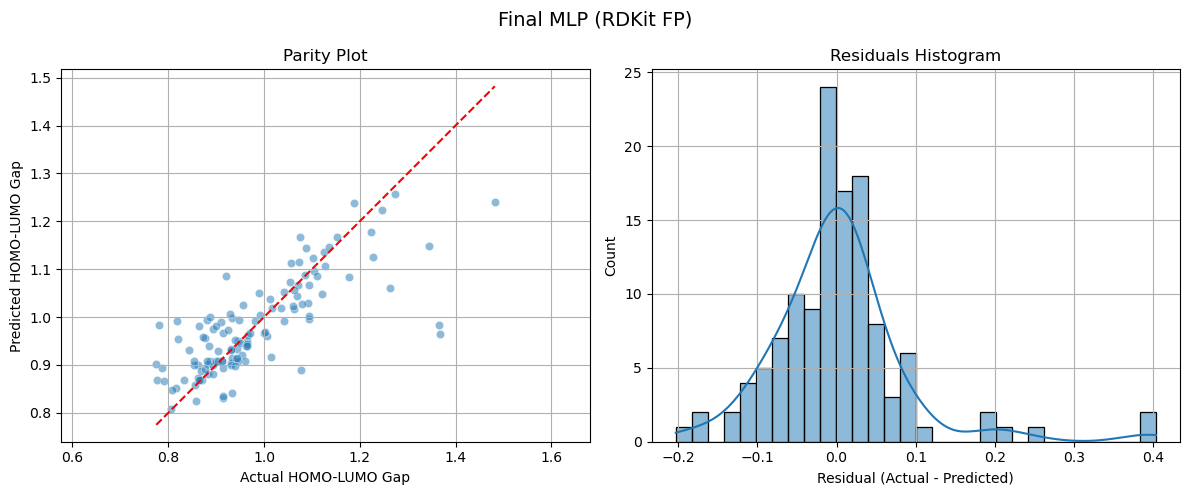

In [79]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
# plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [80]:
# create a save directory
os.makedirs("saved_models_Density", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models_Density/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models_Density/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models_Density/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models_Density/best_mlp_fp_metrics.csv", index=False)

INFO:tensorflow:Assets written to: saved_models_Density/best_mlp_fp_model_keras\assets


If you wanted to reload these later...

In [81]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [83]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['Density'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Tensorising molecules in batches of 3000 ...
613/613 [==================================================] - 3s 5ms/step
Merging batch tensors ...    [DONE]
Epoch 1/100
7/7 [==============================] - 1s 68ms/step - loss: 93.1823 - val_loss: 14.6631
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 10.4289 - val_loss: 8.0492
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 6.4947 - val_loss: 6.9023
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 3.4780 - val_loss: 1.4176
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 1.8569 - val_loss: 1.2053
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 1.4691 - val_loss: 1.4735
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 1.1279 - val_loss: 0.4632
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 0.9264 - val_loss: 0.6285
Epoch 9/100
7/7 [==============================] - 0s 8ms/step 

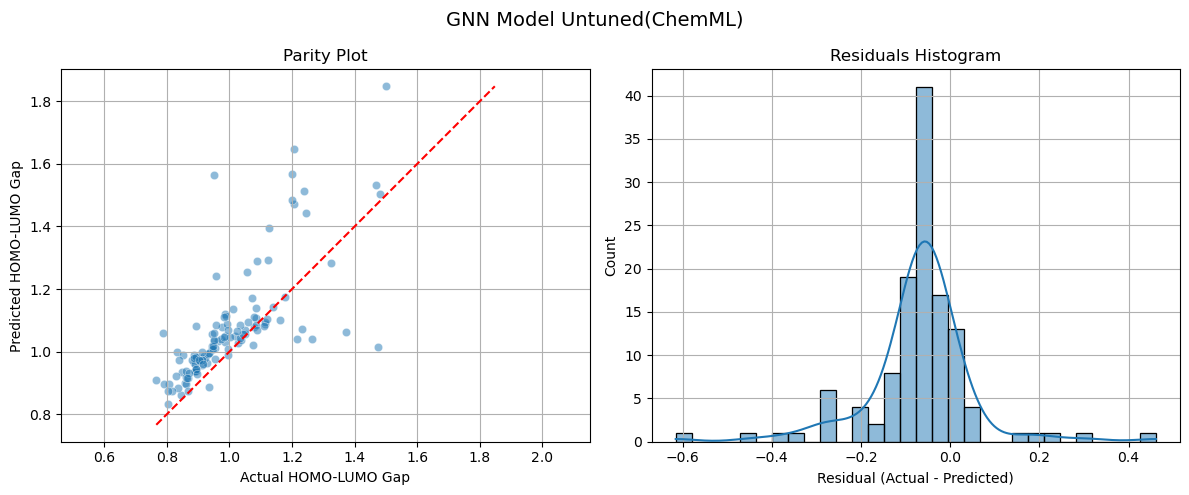

In [84]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [85]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

[I 2025-09-04 20:47:13,349] A new study created in memory with name: no-name-469bc751-c97b-4c52-b72a-c731ddf19af0
[I 2025-09-04 20:47:20,525] Trial 0 finished with value: 0.36156606674194336 and parameters: {'conv_width': 32, 'fp_length': 96, 'n1': 128, 'n2': 96, 'lr': 0.00010757363064199702, 'alpha': 5.711420732088617e-08}. Best is trial 0 with value: 0.36156606674194336.
[I 2025-09-04 20:47:30,308] Trial 1 finished with value: 0.3300926089286804 and parameters: {'conv_width': 16, 'fp_length': 128, 'n1': 160, 'n2': 96, 'lr': 0.001006051995544435, 'alpha': 4.9497638929561956e-08}. Best is trial 1 with value: 0.3300926089286804.
[I 2025-09-04 20:47:38,229] Trial 2 finished with value: 0.32731306552886963 and parameters: {'conv_width': 8, 'fp_length': 96, 'n1': 160, 'n2': 64, 'lr': 0.0013849705943617945, 'alpha': 8.12491542484269e-08}. Best is trial 2 with value: 0.32731306552886963.
[I 2025-09-04 20:47:45,385] Trial 3 finished with value: 0.31615397334098816 and parameters: {'conv_width

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [86]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
8/8 [==============================] - 1s 5ms/step - loss: 477.1330
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 57.0391
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 24.4477
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 7.6944
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 3.6758
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 2.1419
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 1.1786
Epoch 8/200
8/8 [==============================] - 0s 4ms/step - loss: 1.0824
Epoch 9/200
8/8 [==============================] - 0s 4ms/step - loss: 0.9280
Epoch 10/200
8/8 [==============================] - 0s 5ms/step - loss: 0.8394
Epoch 11/200
8/8 [==============================] - 0s 5ms/step - loss: 0.7981
Epoch 12/200
8/8 [==============================] - 0s 4ms/step - loss: 0.7768
Epoch 13/200
8/8 [==============================] - 0s 4m

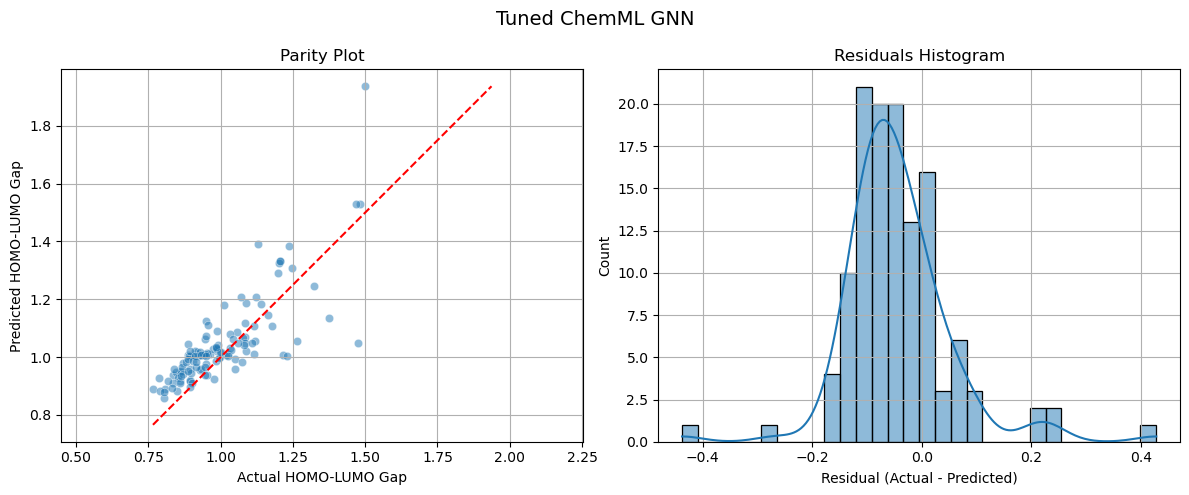

In [87]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [88]:
import json

# make a directory for this specific model
save_dir = "saved_models_Density/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models_Density/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [19]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [20]:
# 1. load OGB dataset 
df_Density = pd.read_csv('cleaned_Density_dataset.csv')


#  Step 2: Extract SMILES from Original Dataset

In [21]:
# 2. Extract SMILES and FFV targets
# Your `df_ffv` already contains the SMILES and FFV columns.
smiles_list = df_Density['SMILES'].tolist()
ffv_list = df_Density['Density'].tolist()

num_mols = len(smiles_list)
print(f"Loaded {num_mols} molecules.")

Loaded 612 molecules.


In [22]:
def compute_rdkit_features(smiles):
    cleaned_smiles = canonicalize_polymer_smiles(smiles)
    mol = Chem.MolFromSmiles(cleaned_smiles)
    if mol is None:
        return [np.nan] * 9  # Update the number of NaNs to match new features

    # Check for empty molecule
    if mol.GetNumAtoms() == 0:
        return [np.nan] * 9

    # Add features that capture size, shape, and interactions
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),  # New: Fraction of sp3 hybridized carbons
        Descriptors.MolLogP(mol),      # New: Octanol-water partition coefficient
        Descriptors.NumSaturatedRings(mol) # New: Number of saturated rings
    ]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])
print(f"Shape of RDKit features: {rdkit_features.shape}") # Should be (N, 9)

Shape of RDKit features: (612, 9)


In [23]:
# Remove rows with NaN values (failed RDKit featurization)
valid_indices = ~np.isnan(rdkit_features).any(axis=1)
rdkit_features = rdkit_features[valid_indices]
smiles_list = np.array(smiles_list)[valid_indices].tolist()
ffv_list = np.array(ffv_list)[valid_indices].tolist()

print(f"Kept {len(smiles_list)} molecules with valid RDKit features.")

Kept 612 molecules with valid RDKit features.


# Step 4: attach RDKit features to PyG data objects

In [24]:
import torch
from torch_geometric.data import Data, DataLoader

# Assuming your previous cells have loaded and processed the data into these lists:
# smiles_list: list of SMILES strings
# rdkit_features: numpy array of RDKit features (N, 6)
# ffv_list: list of FFV values (N,)

# 1. Create a list of PyG Data objects
rdkit_features_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
ffv_targets_tensor = torch.tensor(ffv_list, dtype=torch.float32).view(-1, 1)

data_list = []
for i in range(len(smiles_list)):
    # smiles2graph returns a dictionary
    graph_dict = smiles2graph(smiles_list[i])
    
    # Create the Data object from the dictionary keys, converting to tensors
    # Convert node and edge features to LongTensor 
    data = Data(
        x=torch.tensor(graph_dict['node_feat'], dtype=torch.long),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_feat'], dtype=torch.long),
        rdkit_feats=rdkit_features_tensor[i],
        y=ffv_targets_tensor[i]
    )
    data_list.append(data)

# 2. Split the dataset
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

# 3. Create PyG DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# 4. Verification
for batch in train_loader:
    print(batch)
    print("Batch's node features shape:", batch.x.shape)
    print("Batch's RDKit features shape:", batch.rdkit_feats.shape)
    print("Batch's targets shape:", batch.y.shape)
    print("Batch's 'batch' attribute shape:", batch.batch.shape)
    break

DataBatch(x=[674, 9], edge_index=[2, 1336], edge_attr=[1336, 3], y=[32], rdkit_feats=[288], batch=[674], ptr=[33])
Batch's node features shape: torch.Size([674, 9])
Batch's RDKit features shape: torch.Size([288])
Batch's targets shape: torch.Size([32])
Batch's 'batch' attribute shape: torch.Size([674])


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [25]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 7: training loop 

In [26]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 01: 100%|██████████| 16/16 [00:00<00:00, 32.21it/s]


Epoch 01 | Train Loss: 8.4421 | Val Loss: 0.2935


Epoch 02: 100%|██████████| 16/16 [00:00<00:00, 107.97it/s]


Epoch 02 | Train Loss: 2.3877 | Val Loss: 0.0811


Epoch 03: 100%|██████████| 16/16 [00:00<00:00, 111.68it/s]


Epoch 03 | Train Loss: 0.6830 | Val Loss: 0.4475


Epoch 04: 100%|██████████| 16/16 [00:00<00:00, 109.25it/s]


Epoch 04 | Train Loss: 0.2191 | Val Loss: 0.0553


Epoch 05: 100%|██████████| 16/16 [00:00<00:00, 108.78it/s]


Epoch 05 | Train Loss: 0.1360 | Val Loss: 0.0692


Epoch 06: 100%|██████████| 16/16 [00:00<00:00, 108.30it/s]


Epoch 06 | Train Loss: 0.0854 | Val Loss: 0.0558


Epoch 07: 100%|██████████| 16/16 [00:00<00:00, 106.35it/s]


Epoch 07 | Train Loss: 0.0717 | Val Loss: 0.0822


Epoch 08: 100%|██████████| 16/16 [00:00<00:00, 172.52it/s]


Epoch 08 | Train Loss: 0.0808 | Val Loss: 0.0215


Epoch 09: 100%|██████████| 16/16 [00:00<00:00, 212.31it/s]


Epoch 09 | Train Loss: 0.0623 | Val Loss: 0.0388


Epoch 10: 100%|██████████| 16/16 [00:00<00:00, 206.93it/s]


Epoch 10 | Train Loss: 0.0575 | Val Loss: 0.0366


Epoch 11: 100%|██████████| 16/16 [00:00<00:00, 221.96it/s]


Epoch 11 | Train Loss: 0.0510 | Val Loss: 0.0389


Epoch 12: 100%|██████████| 16/16 [00:00<00:00, 226.86it/s]


Epoch 12 | Train Loss: 0.0511 | Val Loss: 0.0846


Epoch 13: 100%|██████████| 16/16 [00:00<00:00, 221.92it/s]


Epoch 13 | Train Loss: 0.0446 | Val Loss: 0.0533


Epoch 14: 100%|██████████| 16/16 [00:00<00:00, 218.04it/s]


Epoch 14 | Train Loss: 0.0457 | Val Loss: 0.0508


Epoch 15: 100%|██████████| 16/16 [00:00<00:00, 221.54it/s]


Epoch 15 | Train Loss: 0.0471 | Val Loss: 0.0566


Epoch 16: 100%|██████████| 16/16 [00:00<00:00, 201.78it/s]

Epoch 16 | Train Loss: 0.0408 | Val Loss: 0.0263

Epoch 17: 100%|██████████| 16/16 [00:00<00:00, 202.28it/s]


Epoch 17 | Train Loss: 0.0446 | Val Loss: 0.0619


Epoch 18: 100%|██████████| 16/16 [00:00<00:00, 185.43it/s]

Epoch 18 | Train Loss: 0.0456 | Val Loss: 0.0242


C:\Users\mattg\AppData\Local\Temp\ipykernel_2820\2343932047.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, "hy


Early stopping triggered at epoch 18

GNN Evaluation:
        MAE      RMSE  r_squared
0  0.104096  0.146704   0.050815


# Step 8: Optuna tuning of Hybrid GNN

In [27]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [28]:
def objective(trial):
    # hyperparameter search space
    gnn_dim = trial.suggest_categorical("gnn_dim", [512, 1024, 2048])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Corrected Data Splitting for Polymer Data 
    # Split the full data_list into train, validation, and test sets.
    # Note: `data_list` should be created in a previous cell.
    train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
    train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=64)
    
    # model instantiation
    # The rdkit_dim is dynamically taken from the pre-processed features.
    model = HybridGNN(
        gnn_dim=gnn_dim,
        rdkit_dim=rdkit_features.shape[1],
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation=activation
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check and early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch)
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study_Density_2"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass

    study.optimize(objective, n_trials=200, callbacks=[save_study_callback])
    print(study.best_params)
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots
    vis = optuna.visualization
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

[I 2025-09-05 18:39:04,975] A new study created in RDB with name: final_2d_gnn_study_Density_2
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Trial 0 | Epoch 01 | Train Loss: 0.6203 | Val Loss: 0.1188 | Optimizer: RMSprop
Trial 0 | Epoch 02 | Train Loss: 0.4447 | Val Loss: 0.1300 | Optimizer: RMSprop
Trial 0 | Epoch 03 | Train Loss: 0.3143 | Val Loss: 0.2317 | Optimizer: RMSprop
Trial 0 | Epoch 04 | Train Loss: 0.2845 | Val Loss: 0.0483 | Optimizer: RMSprop
Trial 0 | Epoch 05 | Train Loss: 0.2226 | Val Loss: 0.0366 | Optimizer: RMSprop
Trial 0 | Epoch 06 | Train Loss: 0.1776 | Val Loss: 0.0590 | Optimizer: RMSprop
Trial 0 | Epoch 07 | Train Loss: 0.2346 | Val Loss: 0.0654 | Optimizer: RMSprop
Trial 0 | Epoch 08 | Train Loss: 0.1953 | Val Loss: 0.0400 | Optimizer: RMSprop
Trial 0 | Epoch 09 | Train Loss: 0.1311 | Val Loss: 0.0475 | Optimizer: RMSprop
Trial 0 | Epoch 10 | Train Loss: 0.1005 | Val Loss: 0.0507 | Optimizer: RMSprop
Trial 0 | Epoch 11 | Train Loss: 0.0847 | Val Loss: 0.0985 | Optimizer: RMSprop
Trial 0 | Epoch 12 | Train Loss: 0.0947 | Val Loss: 0.0290 | Optimizer: RMSprop
Trial 0 | Epoch 13 | Train Loss: 0.0771 

[I 2025-09-05 18:39:10,157] Trial 0 finished with value: 0.01693216650461664 and parameters: {'gnn_dim': 2048, 'hidden_dim': 512, 'dropout_rate': 0.27721319619189266, 'lr': 2.146053520190911e-05, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'weight_decay': 2.6537610495181396e-05}. Best is trial 0 with value: 0.01693216650461664.


Trial 0 | Epoch 28 | Train Loss: 0.0464 | Val Loss: 0.0196 | Optimizer: RMSprop
Trial 0 - Early stopping triggered at epoch 28
Trial 1 | Epoch 01 | Train Loss: 3.1079 | Val Loss: 0.3748 | Optimizer: AdamW
Trial 1 | Epoch 02 | Train Loss: 3.4178 | Val Loss: 0.2974 | Optimizer: AdamW
Trial 1 | Epoch 03 | Train Loss: 3.8134 | Val Loss: 0.2321 | Optimizer: AdamW
Trial 1 | Epoch 04 | Train Loss: 2.8393 | Val Loss: 0.2025 | Optimizer: AdamW
Trial 1 | Epoch 05 | Train Loss: 4.0786 | Val Loss: 0.1946 | Optimizer: AdamW
Trial 1 | Epoch 06 | Train Loss: 2.5301 | Val Loss: 0.2021 | Optimizer: AdamW
Trial 1 | Epoch 07 | Train Loss: 2.4272 | Val Loss: 0.2065 | Optimizer: AdamW
Trial 1 | Epoch 08 | Train Loss: 3.1370 | Val Loss: 0.2078 | Optimizer: AdamW
Trial 1 | Epoch 09 | Train Loss: 2.6967 | Val Loss: 0.2079 | Optimizer: AdamW
Trial 1 | Epoch 10 | Train Loss: 2.5667 | Val Loss: 0.2093 | Optimizer: AdamW
Trial 1 | Epoch 11 | Train Loss: 2.8628 | Val Loss: 0.2098 | Optimizer: AdamW
Trial 1 | Epoch

[I 2025-09-05 18:39:11,164] Trial 1 finished with value: 0.19464770841355228 and parameters: {'gnn_dim': 512, 'hidden_dim': 256, 'dropout_rate': 0.35024158503779235, 'lr': 8.3846399333843e-06, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 1.6752842919295562e-05}. Best is trial 0 with value: 0.01693216650461664.


Trial 1 | Epoch 15 | Train Loss: 2.5453 | Val Loss: 0.2043 | Optimizer: AdamW
Trial 1 - Early stopping triggered at epoch 15
Trial 2 | Epoch 01 | Train Loss: 4.3167 | Val Loss: 2.5041 | Optimizer: SGD
Trial 2 | Epoch 02 | Train Loss: 3.4092 | Val Loss: 3.4154 | Optimizer: SGD
Trial 2 | Epoch 03 | Train Loss: 2.0625 | Val Loss: 0.4222 | Optimizer: SGD
Trial 2 | Epoch 04 | Train Loss: 1.8879 | Val Loss: 0.4051 | Optimizer: SGD
Trial 2 | Epoch 05 | Train Loss: 1.1975 | Val Loss: 0.6888 | Optimizer: SGD
Trial 2 | Epoch 06 | Train Loss: 1.0267 | Val Loss: 1.0079 | Optimizer: SGD
Trial 2 | Epoch 07 | Train Loss: 0.9959 | Val Loss: 0.9518 | Optimizer: SGD
Trial 2 | Epoch 08 | Train Loss: 0.8664 | Val Loss: 0.6915 | Optimizer: SGD
Trial 2 | Epoch 09 | Train Loss: 0.7446 | Val Loss: 0.5540 | Optimizer: SGD
Trial 2 | Epoch 10 | Train Loss: 0.7603 | Val Loss: 0.5403 | Optimizer: SGD
Trial 2 | Epoch 11 | Train Loss: 0.6959 | Val Loss: 0.5645 | Optimizer: SGD
Trial 2 | Epoch 12 | Train Loss: 0.6979

[I 2025-09-05 18:39:12,395] Trial 2 finished with value: 0.40512498969934424 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.49158806400719873, 'lr': 1.1446565498908277e-05, 'activation': 'GELU', 'optimizer': 'SGD', 'momentum': 0.9195867752693472, 'weight_decay': 2.0717325922746438e-05}. Best is trial 0 with value: 0.01693216650461664.


Trial 2 | Epoch 14 | Train Loss: 0.6816 | Val Loss: 0.5571 | Optimizer: SGD
Trial 2 - Early stopping triggered at epoch 14
Trial 3 | Epoch 01 | Train Loss: 18.9900 | Val Loss: 12.3650 | Optimizer: Adam
Trial 3 | Epoch 02 | Train Loss: 13.8447 | Val Loss: 8.8978 | Optimizer: Adam
Trial 3 | Epoch 03 | Train Loss: 10.7669 | Val Loss: 6.0828 | Optimizer: Adam
Trial 3 | Epoch 04 | Train Loss: 8.0113 | Val Loss: 3.9066 | Optimizer: Adam
Trial 3 | Epoch 05 | Train Loss: 5.0959 | Val Loss: 2.3112 | Optimizer: Adam
Trial 3 | Epoch 06 | Train Loss: 3.4698 | Val Loss: 1.2104 | Optimizer: Adam
Trial 3 | Epoch 07 | Train Loss: 2.4666 | Val Loss: 0.4852 | Optimizer: Adam
Trial 3 | Epoch 08 | Train Loss: 1.5312 | Val Loss: 0.1091 | Optimizer: Adam
Trial 3 | Epoch 09 | Train Loss: 1.0398 | Val Loss: 0.0504 | Optimizer: Adam
Trial 3 | Epoch 10 | Train Loss: 0.9058 | Val Loss: 0.2263 | Optimizer: Adam
Trial 3 | Epoch 11 | Train Loss: 0.9053 | Val Loss: 0.3461 | Optimizer: Adam
Trial 3 | Epoch 12 | Train

[I 2025-09-05 18:39:14,080] Trial 3 finished with value: 0.050412499402858774 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.24170443720173476, 'lr': 1.2092705536238772e-05, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 1.7072504121273374e-05}. Best is trial 0 with value: 0.01693216650461664.


Trial 4 | Epoch 01 | Train Loss: 2.3860 | Val Loss: 0.2497 | Optimizer: Adam
Trial 4 | Epoch 02 | Train Loss: 1.8557 | Val Loss: 0.1807 | Optimizer: Adam
Trial 4 | Epoch 03 | Train Loss: 1.2103 | Val Loss: 0.2546 | Optimizer: Adam
Trial 4 | Epoch 04 | Train Loss: 1.2298 | Val Loss: 0.2501 | Optimizer: Adam
Trial 4 | Epoch 05 | Train Loss: 0.5450 | Val Loss: 0.0613 | Optimizer: Adam
Trial 4 | Epoch 06 | Train Loss: 0.4538 | Val Loss: 0.0680 | Optimizer: Adam
Trial 4 | Epoch 07 | Train Loss: 0.3383 | Val Loss: 0.0491 | Optimizer: Adam
Trial 4 | Epoch 08 | Train Loss: 0.3591 | Val Loss: 0.0325 | Optimizer: Adam
Trial 4 | Epoch 09 | Train Loss: 0.2537 | Val Loss: 0.0609 | Optimizer: Adam
Trial 4 | Epoch 10 | Train Loss: 0.1913 | Val Loss: 0.0304 | Optimizer: Adam
Trial 4 | Epoch 11 | Train Loss: 0.2043 | Val Loss: 0.1072 | Optimizer: Adam
Trial 4 | Epoch 12 | Train Loss: 0.1612 | Val Loss: 0.0297 | Optimizer: Adam
Trial 4 | Epoch 13 | Train Loss: 0.1419 | Val Loss: 0.0962 | Optimizer: Adam

[I 2025-09-05 18:39:17,394] Trial 4 finished with value: 0.01970222155202408 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.39215756428361837, 'lr': 9.150612103161388e-05, 'activation': 'GELU', 'optimizer': 'Adam', 'weight_decay': 1.2532093035748183e-05}. Best is trial 0 with value: 0.01693216650461664.


Trial 5 | Epoch 01 | Train Loss: 0.9166 | Val Loss: 0.2549 | Optimizer: Adam
Trial 5 | Epoch 02 | Train Loss: 0.6102 | Val Loss: 0.1832 | Optimizer: Adam
Trial 5 | Epoch 03 | Train Loss: 0.6643 | Val Loss: 0.1545 | Optimizer: Adam
Trial 5 | Epoch 04 | Train Loss: 0.4932 | Val Loss: 0.1381 | Optimizer: Adam
Trial 5 | Epoch 05 | Train Loss: 0.5042 | Val Loss: 0.1204 | Optimizer: Adam
Trial 5 | Epoch 06 | Train Loss: 0.4117 | Val Loss: 0.1027 | Optimizer: Adam
Trial 5 | Epoch 07 | Train Loss: 0.4024 | Val Loss: 0.0854 | Optimizer: Adam
Trial 5 | Epoch 08 | Train Loss: 0.3939 | Val Loss: 0.0771 | Optimizer: Adam
Trial 5 | Epoch 09 | Train Loss: 0.2609 | Val Loss: 0.0594 | Optimizer: Adam
Trial 5 | Epoch 10 | Train Loss: 0.2495 | Val Loss: 0.0378 | Optimizer: Adam
Trial 5 | Epoch 11 | Train Loss: 0.2385 | Val Loss: 0.0307 | Optimizer: Adam
Trial 5 | Epoch 12 | Train Loss: 0.1624 | Val Loss: 0.0419 | Optimizer: Adam
Trial 5 | Epoch 13 | Train Loss: 0.1384 | Val Loss: 0.0353 | Optimizer: Adam

[I 2025-09-05 18:39:20,757] Trial 5 pruned. 
[I 2025-09-05 18:39:20,879] Trial 6 pruned. 
[I 2025-09-05 18:39:21,003] Trial 7 pruned. 


Trial 6 | Epoch 01 | Train Loss: 1.9070 | Val Loss: 0.5093 | Optimizer: SGD
Trial 7 | Epoch 01 | Train Loss: 4.0921 | Val Loss: 2.3113 | Optimizer: AdamW


[I 2025-09-05 18:39:21,126] Trial 8 pruned. 


Trial 8 | Epoch 01 | Train Loss: 5.7500 | Val Loss: 3.5559 | Optimizer: SGD
Trial 9 | Epoch 01 | Train Loss: 1.5847 | Val Loss: 0.2143 | Optimizer: AdamW
Trial 9 | Epoch 02 | Train Loss: 0.7235 | Val Loss: 0.1782 | Optimizer: AdamW
Trial 9 | Epoch 03 | Train Loss: 0.4051 | Val Loss: 0.0405 | Optimizer: AdamW
Trial 9 | Epoch 04 | Train Loss: 0.2678 | Val Loss: 0.0371 | Optimizer: AdamW
Trial 9 | Epoch 05 | Train Loss: 0.2536 | Val Loss: 0.0430 | Optimizer: AdamW
Trial 9 | Epoch 06 | Train Loss: 0.1919 | Val Loss: 0.2099 | Optimizer: AdamW
Trial 9 | Epoch 07 | Train Loss: 0.2241 | Val Loss: 0.0357 | Optimizer: AdamW
Trial 9 | Epoch 08 | Train Loss: 0.1431 | Val Loss: 0.0860 | Optimizer: AdamW
Trial 9 | Epoch 09 | Train Loss: 0.1463 | Val Loss: 0.0697 | Optimizer: AdamW
Trial 9 | Epoch 10 | Train Loss: 0.1430 | Val Loss: 0.0575 | Optimizer: AdamW
Trial 9 | Epoch 11 | Train Loss: 0.1619 | Val Loss: 0.1144 | Optimizer: AdamW
Trial 9 | Epoch 12 | Train Loss: 0.1508 | Val Loss: 0.0229 | Optim

[I 2025-09-05 18:39:26,214] Trial 9 finished with value: 0.016472897302283317 and parameters: {'gnn_dim': 2048, 'hidden_dim': 256, 'dropout_rate': 0.47214814900125884, 'lr': 0.0001557372161456676, 'activation': 'GELU', 'optimizer': 'AdamW', 'weight_decay': 8.373560971213513e-06}. Best is trial 9 with value: 0.016472897302283317.


Trial 9 | Epoch 29 | Train Loss: 0.0714 | Val Loss: 0.0558 | Optimizer: AdamW
Trial 9 - Early stopping triggered at epoch 29
Trial 10 | Epoch 01 | Train Loss: 3.1360 | Val Loss: 0.2507 | Optimizer: AdamW
Trial 10 | Epoch 02 | Train Loss: 1.1396 | Val Loss: 0.1510 | Optimizer: AdamW
Trial 10 | Epoch 03 | Train Loss: 0.4497 | Val Loss: 0.0268 | Optimizer: AdamW
Trial 10 | Epoch 04 | Train Loss: 0.2870 | Val Loss: 0.0432 | Optimizer: AdamW
Trial 10 | Epoch 05 | Train Loss: 0.2389 | Val Loss: 0.0289 | Optimizer: AdamW
Trial 10 | Epoch 06 | Train Loss: 0.2050 | Val Loss: 0.1084 | Optimizer: AdamW
Trial 10 | Epoch 07 | Train Loss: 0.1483 | Val Loss: 0.3001 | Optimizer: AdamW
Trial 10 | Epoch 08 | Train Loss: 0.1890 | Val Loss: 0.2032 | Optimizer: AdamW
Trial 10 | Epoch 09 | Train Loss: 0.1195 | Val Loss: 0.1053 | Optimizer: AdamW
Trial 10 | Epoch 10 | Train Loss: 0.1350 | Val Loss: 0.0680 | Optimizer: AdamW
Trial 10 | Epoch 11 | Train Loss: 0.1154 | Val Loss: 0.1252 | Optimizer: AdamW
Trial 

[I 2025-09-05 18:39:28,575] Trial 10 finished with value: 0.026797299520397673 and parameters: {'gnn_dim': 2048, 'hidden_dim': 384, 'dropout_rate': 0.4825521905542639, 'lr': 0.0004330526812719305, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 9.458402948704905e-05}. Best is trial 9 with value: 0.016472897302283317.


Trial 10 | Epoch 13 | Train Loss: 0.1318 | Val Loss: 0.1162 | Optimizer: AdamW
Trial 10 - Early stopping triggered at epoch 13


[I 2025-09-05 18:39:28,897] Trial 11 pruned. 


Trial 11 | Epoch 01 | Train Loss: 10.6282 | Val Loss: 0.2561 | Optimizer: RMSprop
Trial 12 | Epoch 01 | Train Loss: 183.2245 | Val Loss: 0.0739 | Optimizer: RMSprop
Trial 12 | Epoch 02 | Train Loss: 0.3934 | Val Loss: 0.4805 | Optimizer: RMSprop
Trial 12 | Epoch 03 | Train Loss: 0.3375 | Val Loss: 0.1150 | Optimizer: RMSprop
Trial 12 | Epoch 04 | Train Loss: 0.2549 | Val Loss: 0.2164 | Optimizer: RMSprop


[I 2025-09-05 18:39:29,893] Trial 12 pruned. 


Trial 12 | Epoch 05 | Train Loss: 0.3947 | Val Loss: 0.2568 | Optimizer: RMSprop
Trial 13 | Epoch 01 | Train Loss: 1.2181 | Val Loss: 0.1053 | Optimizer: RMSprop
Trial 13 | Epoch 02 | Train Loss: 0.7164 | Val Loss: 0.1337 | Optimizer: RMSprop
Trial 13 | Epoch 03 | Train Loss: 0.3510 | Val Loss: 0.1614 | Optimizer: RMSprop
Trial 13 | Epoch 04 | Train Loss: 0.2480 | Val Loss: 0.0694 | Optimizer: RMSprop


[I 2025-09-05 18:39:30,850] Trial 13 pruned. 


Trial 13 | Epoch 05 | Train Loss: 0.2357 | Val Loss: 0.3162 | Optimizer: RMSprop
Trial 14 | Epoch 01 | Train Loss: 1.2309 | Val Loss: 0.2124 | Optimizer: AdamW
Trial 14 | Epoch 02 | Train Loss: 0.6644 | Val Loss: 0.1355 | Optimizer: AdamW
Trial 14 | Epoch 03 | Train Loss: 0.3435 | Val Loss: 0.0708 | Optimizer: AdamW
Trial 14 | Epoch 04 | Train Loss: 0.1579 | Val Loss: 0.0591 | Optimizer: AdamW
Trial 14 | Epoch 05 | Train Loss: 0.1718 | Val Loss: 0.0482 | Optimizer: AdamW
Trial 14 | Epoch 06 | Train Loss: 0.1292 | Val Loss: 0.0644 | Optimizer: AdamW
Trial 14 | Epoch 07 | Train Loss: 0.0886 | Val Loss: 0.0382 | Optimizer: AdamW
Trial 14 | Epoch 08 | Train Loss: 0.0747 | Val Loss: 0.0471 | Optimizer: AdamW
Trial 14 | Epoch 09 | Train Loss: 0.0629 | Val Loss: 0.0267 | Optimizer: AdamW
Trial 14 | Epoch 10 | Train Loss: 0.0548 | Val Loss: 0.0242 | Optimizer: AdamW
Trial 14 | Epoch 11 | Train Loss: 0.0549 | Val Loss: 0.0219 | Optimizer: AdamW
Trial 14 | Epoch 12 | Train Loss: 0.0496 | Val Los

[I 2025-09-05 18:39:43,256] Trial 14 finished with value: 0.004475641686811435 and parameters: {'gnn_dim': 2048, 'hidden_dim': 384, 'dropout_rate': 0.3418699047127467, 'lr': 0.0001898023233705763, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 7.145360504254293e-06}. Best is trial 14 with value: 0.004475641686811435.


Trial 14 | Epoch 67 | Train Loss: 0.0180 | Val Loss: 0.0081 | Optimizer: AdamW
Trial 14 - Early stopping triggered at epoch 67
Trial 15 | Epoch 01 | Train Loss: 1.8817 | Val Loss: 0.1864 | Optimizer: AdamW
Trial 15 | Epoch 02 | Train Loss: 0.4081 | Val Loss: 0.0460 | Optimizer: AdamW
Trial 15 | Epoch 03 | Train Loss: 0.1873 | Val Loss: 0.0312 | Optimizer: AdamW
Trial 15 | Epoch 04 | Train Loss: 0.1283 | Val Loss: 0.0261 | Optimizer: AdamW
Trial 15 | Epoch 05 | Train Loss: 0.0673 | Val Loss: 0.0307 | Optimizer: AdamW
Trial 15 | Epoch 06 | Train Loss: 0.0571 | Val Loss: 0.0454 | Optimizer: AdamW
Trial 15 | Epoch 07 | Train Loss: 0.0433 | Val Loss: 0.0287 | Optimizer: AdamW
Trial 15 | Epoch 08 | Train Loss: 0.0427 | Val Loss: 0.0174 | Optimizer: AdamW
Trial 15 | Epoch 09 | Train Loss: 0.0303 | Val Loss: 0.0321 | Optimizer: AdamW
Trial 15 | Epoch 10 | Train Loss: 0.0297 | Val Loss: 0.0201 | Optimizer: AdamW
Trial 15 | Epoch 11 | Train Loss: 0.0424 | Val Loss: 0.0274 | Optimizer: AdamW
Tria

[I 2025-09-05 18:39:51,099] Trial 15 pruned. 


Trial 15 | Epoch 45 | Train Loss: 0.0151 | Val Loss: 0.0086 | Optimizer: AdamW
Trial 16 | Epoch 01 | Train Loss: 1.7093 | Val Loss: 0.2284 | Optimizer: AdamW
Trial 16 | Epoch 02 | Train Loss: 0.9041 | Val Loss: 0.1418 | Optimizer: AdamW
Trial 16 | Epoch 03 | Train Loss: 0.5300 | Val Loss: 0.0801 | Optimizer: AdamW
Trial 16 | Epoch 04 | Train Loss: 0.2803 | Val Loss: 0.0461 | Optimizer: AdamW
Trial 16 | Epoch 05 | Train Loss: 0.1747 | Val Loss: 0.0305 | Optimizer: AdamW
Trial 16 | Epoch 06 | Train Loss: 0.1355 | Val Loss: 0.0559 | Optimizer: AdamW
Trial 16 | Epoch 07 | Train Loss: 0.1022 | Val Loss: 0.0415 | Optimizer: AdamW
Trial 16 | Epoch 08 | Train Loss: 0.0891 | Val Loss: 0.0258 | Optimizer: AdamW
Trial 16 | Epoch 09 | Train Loss: 0.0813 | Val Loss: 0.0411 | Optimizer: AdamW
Trial 16 | Epoch 10 | Train Loss: 0.0786 | Val Loss: 0.0420 | Optimizer: AdamW
Trial 16 | Epoch 11 | Train Loss: 0.0727 | Val Loss: 0.0226 | Optimizer: AdamW
Trial 16 | Epoch 12 | Train Loss: 0.0652 | Val Loss:

[I 2025-09-05 18:39:59,083] Trial 16 pruned. 


Trial 16 | Epoch 45 | Train Loss: 0.0205 | Val Loss: 0.0085 | Optimizer: AdamW
Trial 17 | Epoch 01 | Train Loss: 1.1033 | Val Loss: 0.0513 | Optimizer: AdamW
Trial 17 | Epoch 02 | Train Loss: 0.2681 | Val Loss: 0.0632 | Optimizer: AdamW
Trial 17 | Epoch 03 | Train Loss: 0.1833 | Val Loss: 0.0316 | Optimizer: AdamW
Trial 17 | Epoch 04 | Train Loss: 0.1385 | Val Loss: 0.0791 | Optimizer: AdamW
Trial 17 | Epoch 05 | Train Loss: 0.0804 | Val Loss: 0.0546 | Optimizer: AdamW
Trial 17 | Epoch 06 | Train Loss: 0.0721 | Val Loss: 0.0257 | Optimizer: AdamW
Trial 17 | Epoch 07 | Train Loss: 0.0668 | Val Loss: 0.0376 | Optimizer: AdamW
Trial 17 | Epoch 08 | Train Loss: 0.0642 | Val Loss: 0.0190 | Optimizer: AdamW
Trial 17 | Epoch 09 | Train Loss: 0.0759 | Val Loss: 0.0357 | Optimizer: AdamW
Trial 17 | Epoch 10 | Train Loss: 0.0545 | Val Loss: 0.0248 | Optimizer: AdamW
Trial 17 | Epoch 11 | Train Loss: 0.0476 | Val Loss: 0.0186 | Optimizer: AdamW
Trial 17 | Epoch 12 | Train Loss: 0.0449 | Val Loss:

[I 2025-09-05 18:40:04,504] Trial 17 finished with value: 0.008901943595205642 and parameters: {'gnn_dim': 2048, 'hidden_dim': 384, 'dropout_rate': 0.38660318250511916, 'lr': 0.00046326826351544045, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 8.100135341326319e-06}. Best is trial 14 with value: 0.004475641686811435.


Trial 17 | Epoch 31 | Train Loss: 0.0176 | Val Loss: 0.0114 | Optimizer: AdamW
Trial 17 - Early stopping triggered at epoch 31


[I 2025-09-05 18:40:04,855] Trial 18 pruned. 
[I 2025-09-05 18:40:05,018] Trial 19 pruned. 


Trial 18 | Epoch 01 | Train Loss: 1.0828 | Val Loss: 0.9261 | Optimizer: AdamW
Trial 19 | Epoch 01 | Train Loss: 1.6340 | Val Loss: 2.3185 | Optimizer: AdamW
Trial 20 | Epoch 01 | Train Loss: 1.2457 | Val Loss: 0.0844 | Optimizer: AdamW
Trial 20 | Epoch 02 | Train Loss: 0.5823 | Val Loss: 0.2282 | Optimizer: AdamW
Trial 20 | Epoch 03 | Train Loss: 0.3530 | Val Loss: 0.0432 | Optimizer: AdamW
Trial 20 | Epoch 04 | Train Loss: 0.2071 | Val Loss: 0.1139 | Optimizer: AdamW
Trial 20 | Epoch 05 | Train Loss: 0.1270 | Val Loss: 0.0481 | Optimizer: AdamW
Trial 20 | Epoch 06 | Train Loss: 0.1011 | Val Loss: 0.0976 | Optimizer: AdamW
Trial 20 | Epoch 07 | Train Loss: 0.0758 | Val Loss: 0.0467 | Optimizer: AdamW
Trial 20 | Epoch 08 | Train Loss: 0.0822 | Val Loss: 0.0487 | Optimizer: AdamW
Trial 20 | Epoch 09 | Train Loss: 0.0681 | Val Loss: 0.0363 | Optimizer: AdamW
Trial 20 | Epoch 10 | Train Loss: 0.0556 | Val Loss: 0.0501 | Optimizer: AdamW
Trial 20 | Epoch 11 | Train Loss: 0.0518 | Val Loss:

[I 2025-09-05 18:40:07,951] Trial 20 pruned. 
[I 2025-09-05 18:40:08,275] Trial 21 pruned. 


Trial 21 | Epoch 01 | Train Loss: 1.4402 | Val Loss: 0.3259 | Optimizer: AdamW
Trial 22 | Epoch 01 | Train Loss: 0.7243 | Val Loss: 0.2007 | Optimizer: AdamW
Trial 22 | Epoch 02 | Train Loss: 0.5823 | Val Loss: 0.1621 | Optimizer: AdamW
Trial 22 | Epoch 03 | Train Loss: 0.5714 | Val Loss: 0.1096 | Optimizer: AdamW
Trial 22 | Epoch 04 | Train Loss: 0.3109 | Val Loss: 0.1188 | Optimizer: AdamW


[I 2025-09-05 18:40:09,096] Trial 22 pruned. 
[I 2025-09-05 18:40:09,492] Trial 23 pruned. 


Trial 23 | Epoch 01 | Train Loss: 1.6080 | Val Loss: 0.9399 | Optimizer: AdamW
Trial 24 | Epoch 01 | Train Loss: 0.8845 | Val Loss: 0.2243 | Optimizer: AdamW
Trial 24 | Epoch 02 | Train Loss: 0.7186 | Val Loss: 0.0809 | Optimizer: AdamW


[I 2025-09-05 18:40:10,336] Trial 24 pruned. 


Trial 24 | Epoch 03 | Train Loss: 0.3781 | Val Loss: 0.1454 | Optimizer: AdamW
Trial 24 | Epoch 04 | Train Loss: 0.2834 | Val Loss: 0.0999 | Optimizer: AdamW
Trial 25 | Epoch 01 | Train Loss: 1.8126 | Val Loss: 0.1541 | Optimizer: AdamW
Trial 25 | Epoch 02 | Train Loss: 0.9625 | Val Loss: 0.0992 | Optimizer: AdamW
Trial 25 | Epoch 03 | Train Loss: 0.3964 | Val Loss: 0.0759 | Optimizer: AdamW
Trial 25 | Epoch 04 | Train Loss: 0.2401 | Val Loss: 0.0764 | Optimizer: AdamW
Trial 25 | Epoch 05 | Train Loss: 0.2250 | Val Loss: 0.0325 | Optimizer: AdamW
Trial 25 | Epoch 06 | Train Loss: 0.2209 | Val Loss: 0.1216 | Optimizer: AdamW
Trial 25 | Epoch 07 | Train Loss: 0.1558 | Val Loss: 0.0390 | Optimizer: AdamW
Trial 25 | Epoch 08 | Train Loss: 0.1562 | Val Loss: 0.0534 | Optimizer: AdamW
Trial 25 | Epoch 09 | Train Loss: 0.1335 | Val Loss: 0.0214 | Optimizer: AdamW
Trial 25 | Epoch 10 | Train Loss: 0.1342 | Val Loss: 0.0570 | Optimizer: AdamW
Trial 25 | Epoch 11 | Train Loss: 0.0857 | Val Loss:

[I 2025-09-05 18:40:15,496] Trial 25 pruned. 
[I 2025-09-05 18:40:15,811] Trial 26 pruned. 


Trial 26 | Epoch 01 | Train Loss: 1.4067 | Val Loss: 0.6381 | Optimizer: AdamW


[I 2025-09-05 18:40:16,109] Trial 27 pruned. 


Trial 27 | Epoch 01 | Train Loss: 1.1780 | Val Loss: 0.3482 | Optimizer: SGD
Trial 28 | Epoch 01 | Train Loss: 1.5946 | Val Loss: 0.2392 | Optimizer: Adam


[I 2025-09-05 18:40:16,361] Trial 28 pruned. 


Trial 28 | Epoch 02 | Train Loss: 1.7044 | Val Loss: 0.3575 | Optimizer: Adam
Trial 29 | Epoch 01 | Train Loss: 3.2496 | Val Loss: 0.2426 | Optimizer: RMSprop
Trial 29 | Epoch 02 | Train Loss: 0.8497 | Val Loss: 0.1005 | Optimizer: RMSprop


[I 2025-09-05 18:40:16,655] Trial 29 pruned. 


Trial 29 | Epoch 03 | Train Loss: 0.5039 | Val Loss: 0.3357 | Optimizer: RMSprop
Trial 29 | Epoch 04 | Train Loss: 0.6078 | Val Loss: 0.3586 | Optimizer: RMSprop
Trial 30 | Epoch 01 | Train Loss: 0.9021 | Val Loss: 0.1685 | Optimizer: AdamW
Trial 30 | Epoch 02 | Train Loss: 0.4926 | Val Loss: 0.1865 | Optimizer: AdamW
Trial 30 | Epoch 03 | Train Loss: 0.1396 | Val Loss: 0.0753 | Optimizer: AdamW
Trial 30 | Epoch 04 | Train Loss: 0.1239 | Val Loss: 0.0361 | Optimizer: AdamW
Trial 30 | Epoch 05 | Train Loss: 0.0902 | Val Loss: 0.0331 | Optimizer: AdamW
Trial 30 | Epoch 06 | Train Loss: 0.0585 | Val Loss: 0.0235 | Optimizer: AdamW
Trial 30 | Epoch 07 | Train Loss: 0.0792 | Val Loss: 0.0761 | Optimizer: AdamW
Trial 30 | Epoch 08 | Train Loss: 0.0573 | Val Loss: 0.0501 | Optimizer: AdamW
Trial 30 | Epoch 09 | Train Loss: 0.0479 | Val Loss: 0.0458 | Optimizer: AdamW
Trial 30 | Epoch 10 | Train Loss: 0.0550 | Val Loss: 0.0217 | Optimizer: AdamW
Trial 30 | Epoch 11 | Train Loss: 0.0381 | Val L

[I 2025-09-05 18:40:24,431] Trial 30 pruned. 


Trial 30 | Epoch 45 | Train Loss: 0.0132 | Val Loss: 0.0081 | Optimizer: AdamW
Trial 31 | Epoch 01 | Train Loss: 0.6944 | Val Loss: 0.1781 | Optimizer: RMSprop
Trial 31 | Epoch 02 | Train Loss: 0.4311 | Val Loss: 0.0848 | Optimizer: RMSprop
Trial 31 | Epoch 03 | Train Loss: 0.2429 | Val Loss: 0.0470 | Optimizer: RMSprop
Trial 31 | Epoch 04 | Train Loss: 0.2661 | Val Loss: 0.0538 | Optimizer: RMSprop
Trial 31 | Epoch 05 | Train Loss: 0.2076 | Val Loss: 0.0373 | Optimizer: RMSprop
Trial 31 | Epoch 06 | Train Loss: 0.1569 | Val Loss: 0.0389 | Optimizer: RMSprop
Trial 31 | Epoch 07 | Train Loss: 0.1881 | Val Loss: 0.0333 | Optimizer: RMSprop
Trial 31 | Epoch 08 | Train Loss: 0.1400 | Val Loss: 0.0832 | Optimizer: RMSprop
Trial 31 | Epoch 09 | Train Loss: 0.1084 | Val Loss: 0.0197 | Optimizer: RMSprop
Trial 31 | Epoch 10 | Train Loss: 0.0969 | Val Loss: 0.0783 | Optimizer: RMSprop
Trial 31 | Epoch 11 | Train Loss: 0.0937 | Val Loss: 0.0570 | Optimizer: RMSprop
Trial 31 | Epoch 12 | Train Lo

[I 2025-09-05 18:40:28,580] Trial 31 finished with value: 0.01680971009238642 and parameters: {'gnn_dim': 2048, 'hidden_dim': 512, 'dropout_rate': 0.24275520295049607, 'lr': 3.579208156712084e-05, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'weight_decay': 1.9790403478294017e-05}. Best is trial 14 with value: 0.004475641686811435.


Trial 32 | Epoch 01 | Train Loss: 0.9100 | Val Loss: 0.1490 | Optimizer: RMSprop
Trial 32 | Epoch 02 | Train Loss: 0.4334 | Val Loss: 0.2689 | Optimizer: RMSprop
Trial 32 | Epoch 03 | Train Loss: 0.3677 | Val Loss: 0.0610 | Optimizer: RMSprop
Trial 32 | Epoch 04 | Train Loss: 0.3331 | Val Loss: 0.0905 | Optimizer: RMSprop


[I 2025-09-05 18:40:29,549] Trial 32 pruned. 


Trial 32 | Epoch 05 | Train Loss: 0.2555 | Val Loss: 0.0580 | Optimizer: RMSprop
Trial 33 | Epoch 01 | Train Loss: 1.8260 | Val Loss: 0.1804 | Optimizer: RMSprop
Trial 33 | Epoch 02 | Train Loss: 1.1242 | Val Loss: 0.7310 | Optimizer: RMSprop


[I 2025-09-05 18:40:30,030] Trial 33 pruned. 


Trial 34 | Epoch 01 | Train Loss: 2.4938 | Val Loss: 0.1403 | Optimizer: RMSprop
Trial 34 | Epoch 02 | Train Loss: 0.6308 | Val Loss: 0.5575 | Optimizer: RMSprop


[I 2025-09-05 18:40:30,836] Trial 34 pruned. 


Trial 34 | Epoch 03 | Train Loss: 0.5098 | Val Loss: 0.2457 | Optimizer: RMSprop
Trial 34 | Epoch 04 | Train Loss: 0.3607 | Val Loss: 0.1197 | Optimizer: RMSprop


[I 2025-09-05 18:40:30,998] Trial 35 pruned. 


Trial 35 | Epoch 01 | Train Loss: 2.2396 | Val Loss: 0.6587 | Optimizer: AdamW
Trial 36 | Epoch 01 | Train Loss: 0.8042 | Val Loss: 0.2059 | Optimizer: Adam
Trial 36 | Epoch 02 | Train Loss: 0.3123 | Val Loss: 0.1026 | Optimizer: Adam
Trial 36 | Epoch 03 | Train Loss: 0.2792 | Val Loss: 0.0779 | Optimizer: Adam
Trial 36 | Epoch 04 | Train Loss: 0.2136 | Val Loss: 0.0692 | Optimizer: Adam


[I 2025-09-05 18:40:31,809] Trial 36 pruned. 
[I 2025-09-05 18:40:31,931] Trial 37 pruned. 
[I 2025-09-05 18:40:32,089] Trial 38 pruned. 


Trial 37 | Epoch 01 | Train Loss: 6.7310 | Val Loss: 0.7795 | Optimizer: SGD
Trial 38 | Epoch 01 | Train Loss: 2.3189 | Val Loss: 0.3282 | Optimizer: RMSprop
Trial 39 | Epoch 01 | Train Loss: 1.0135 | Val Loss: 0.1414 | Optimizer: Adam
Trial 39 | Epoch 02 | Train Loss: 0.4604 | Val Loss: 0.1622 | Optimizer: Adam
Trial 39 | Epoch 03 | Train Loss: 0.5499 | Val Loss: 0.1010 | Optimizer: Adam
Trial 39 | Epoch 04 | Train Loss: 0.4288 | Val Loss: 0.1110 | Optimizer: Adam


[I 2025-09-05 18:40:32,905] Trial 39 pruned. 
[I 2025-09-05 18:40:33,030] Trial 40 pruned. 


Trial 40 | Epoch 01 | Train Loss: 4.3389 | Val Loss: 0.8584 | Optimizer: AdamW
Trial 41 | Epoch 01 | Train Loss: 0.9728 | Val Loss: 0.0762 | Optimizer: RMSprop
Trial 41 | Epoch 02 | Train Loss: 0.4801 | Val Loss: 0.2021 | Optimizer: RMSprop
Trial 41 | Epoch 03 | Train Loss: 0.5091 | Val Loss: 0.0643 | Optimizer: RMSprop
Trial 41 | Epoch 04 | Train Loss: 0.3987 | Val Loss: 0.0436 | Optimizer: RMSprop
Trial 41 | Epoch 05 | Train Loss: 0.2989 | Val Loss: 0.1247 | Optimizer: RMSprop
Trial 41 | Epoch 06 | Train Loss: 0.2549 | Val Loss: 0.1066 | Optimizer: RMSprop
Trial 41 | Epoch 07 | Train Loss: 0.2283 | Val Loss: 0.0341 | Optimizer: RMSprop
Trial 41 | Epoch 08 | Train Loss: 0.2178 | Val Loss: 0.1294 | Optimizer: RMSprop
Trial 41 | Epoch 09 | Train Loss: 0.1997 | Val Loss: 0.0851 | Optimizer: RMSprop
Trial 41 | Epoch 10 | Train Loss: 0.1842 | Val Loss: 0.0212 | Optimizer: RMSprop
Trial 41 | Epoch 11 | Train Loss: 0.1271 | Val Loss: 0.0238 | Optimizer: RMSprop
Trial 41 | Epoch 12 | Train Lo

[I 2025-09-05 18:40:37,913] Trial 41 finished with value: 0.019018147178754514 and parameters: {'gnn_dim': 2048, 'hidden_dim': 512, 'dropout_rate': 0.23892512818898862, 'lr': 2.0182880030947868e-05, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'weight_decay': 6.857892507557257e-05}. Best is trial 14 with value: 0.004475641686811435.


Trial 41 | Epoch 29 | Train Loss: 0.0437 | Val Loss: 0.0426 | Optimizer: RMSprop
Trial 41 - Early stopping triggered at epoch 29
Trial 42 | Epoch 01 | Train Loss: 0.8684 | Val Loss: 0.0538 | Optimizer: RMSprop
Trial 42 | Epoch 02 | Train Loss: 0.2788 | Val Loss: 0.2370 | Optimizer: RMSprop
Trial 42 | Epoch 03 | Train Loss: 0.3367 | Val Loss: 0.0876 | Optimizer: RMSprop
Trial 42 | Epoch 04 | Train Loss: 0.2993 | Val Loss: 0.0247 | Optimizer: RMSprop
Trial 42 | Epoch 05 | Train Loss: 0.2447 | Val Loss: 0.0745 | Optimizer: RMSprop
Trial 42 | Epoch 06 | Train Loss: 0.2460 | Val Loss: 0.0217 | Optimizer: RMSprop
Trial 42 | Epoch 07 | Train Loss: 0.2826 | Val Loss: 0.0309 | Optimizer: RMSprop
Trial 42 | Epoch 08 | Train Loss: 0.2254 | Val Loss: 0.0261 | Optimizer: RMSprop
Trial 42 | Epoch 09 | Train Loss: 0.2549 | Val Loss: 0.1218 | Optimizer: RMSprop
Trial 42 | Epoch 10 | Train Loss: 0.2432 | Val Loss: 0.0291 | Optimizer: RMSprop
Trial 42 | Epoch 11 | Train Loss: 0.2486 | Val Loss: 0.0569 |

[I 2025-09-05 18:40:40,669] Trial 42 finished with value: 0.021747806394586757 and parameters: {'gnn_dim': 2048, 'hidden_dim': 512, 'dropout_rate': 0.2207438281371931, 'lr': 1.0520175262066239e-05, 'activation': 'ReLU', 'optimizer': 'RMSprop', 'weight_decay': 3.0140657785095398e-05}. Best is trial 14 with value: 0.004475641686811435.


Trial 43 | Epoch 01 | Train Loss: 0.6914 | Val Loss: 0.2106 | Optimizer: RMSprop
Trial 43 | Epoch 02 | Train Loss: 0.4877 | Val Loss: 0.1045 | Optimizer: RMSprop
Trial 43 | Epoch 03 | Train Loss: 0.3908 | Val Loss: 0.0325 | Optimizer: RMSprop
Trial 43 | Epoch 04 | Train Loss: 0.3701 | Val Loss: 0.1837 | Optimizer: RMSprop
Trial 43 | Epoch 05 | Train Loss: 0.2898 | Val Loss: 0.0660 | Optimizer: RMSprop
Trial 43 | Epoch 06 | Train Loss: 0.2827 | Val Loss: 0.0266 | Optimizer: RMSprop
Trial 43 | Epoch 07 | Train Loss: 0.1963 | Val Loss: 0.0802 | Optimizer: RMSprop
Trial 43 | Epoch 08 | Train Loss: 0.2192 | Val Loss: 0.2107 | Optimizer: RMSprop
Trial 43 | Epoch 09 | Train Loss: 0.2241 | Val Loss: 0.0531 | Optimizer: RMSprop
Trial 43 | Epoch 10 | Train Loss: 0.1737 | Val Loss: 0.0870 | Optimizer: RMSprop
Trial 43 | Epoch 11 | Train Loss: 0.1631 | Val Loss: 0.0613 | Optimizer: RMSprop
Trial 43 | Epoch 12 | Train Loss: 0.1605 | Val Loss: 0.0512 | Optimizer: RMSprop
Trial 43 | Epoch 13 | Train 

[I 2025-09-05 18:40:45,708] Trial 43 pruned. 
[I 2025-09-05 18:40:46,024] Trial 44 pruned. 


Trial 44 | Epoch 01 | Train Loss: 1.3633 | Val Loss: 1.2692 | Optimizer: SGD


[I 2025-09-05 18:40:46,329] Trial 45 pruned. 


Trial 45 | Epoch 01 | Train Loss: 1.3566 | Val Loss: 0.6875 | Optimizer: RMSprop


[I 2025-09-05 18:40:46,638] Trial 46 pruned. 
[I 2025-09-05 18:40:46,759] Trial 47 pruned. 


Trial 46 | Epoch 01 | Train Loss: 3.0170 | Val Loss: 2.0158 | Optimizer: AdamW
Trial 47 | Epoch 01 | Train Loss: 3.1372 | Val Loss: 0.3663 | Optimizer: RMSprop


[I 2025-09-05 18:40:46,940] Trial 48 pruned. 


Trial 48 | Epoch 01 | Train Loss: 1.1502 | Val Loss: 0.3515 | Optimizer: Adam
Trial 49 | Epoch 01 | Train Loss: 1.2588 | Val Loss: 0.1892 | Optimizer: AdamW
Trial 49 | Epoch 02 | Train Loss: 0.9865 | Val Loss: 0.1562 | Optimizer: AdamW
Trial 49 | Epoch 03 | Train Loss: 0.6440 | Val Loss: 0.0487 | Optimizer: AdamW
Trial 49 | Epoch 04 | Train Loss: 0.4507 | Val Loss: 0.1071 | Optimizer: AdamW
Trial 49 | Epoch 05 | Train Loss: 0.2847 | Val Loss: 0.1746 | Optimizer: AdamW
Trial 49 | Epoch 06 | Train Loss: 0.1866 | Val Loss: 0.0427 | Optimizer: AdamW
Trial 49 | Epoch 07 | Train Loss: 0.1785 | Val Loss: 0.1989 | Optimizer: AdamW
Trial 49 | Epoch 08 | Train Loss: 0.1651 | Val Loss: 0.1301 | Optimizer: AdamW
Trial 49 | Epoch 09 | Train Loss: 0.1599 | Val Loss: 0.1007 | Optimizer: AdamW
Trial 49 | Epoch 10 | Train Loss: 0.1264 | Val Loss: 0.1345 | Optimizer: AdamW
Trial 49 | Epoch 11 | Train Loss: 0.1325 | Val Loss: 0.0669 | Optimizer: AdamW
Trial 49 | Epoch 12 | Train Loss: 0.1218 | Val Loss: 

[I 2025-09-05 18:40:49,667] Trial 49 pruned. 


Trial 49 | Epoch 15 | Train Loss: 0.1190 | Val Loss: 0.1098 | Optimizer: AdamW


[I 2025-09-05 18:40:49,985] Trial 50 pruned. 


Trial 50 | Epoch 01 | Train Loss: 0.9090 | Val Loss: 0.2619 | Optimizer: SGD


: 

In [99]:
print(study.best_params)

{'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.3735260731607324, 'lr': 0.0005956024201538505, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 8.619671341229739e-06}


# Step 9: Retrain with best prameters

In [100]:
# The best_params dictionary is available from your Optuna study
best_params = study.best_params

# Use the same train/val/test sets as the Optuna objective function.
# You need to make sure `data_list` is available in this scope.
train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
 
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# reinitialize model
model = HybridGNN(
    gnn_dim=best_params['gnn_dim'],
    rdkit_dim=rdkit_features.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    momentum = best_params['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")


num_epochs = 100
total_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and final evaluation on the TEST set
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
final_test_loss, test_preds, test_targets = evaluate(model, test_loader)
metrics = regression_metrics(test_targets.numpy(), test_preds.numpy())
print("\nFinal Test Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Test Loss: {final_test_loss:.4f}")

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Epoch 01 | Train Loss: 1.5743 | Val Loss: 0.2987
Epoch 02 | Train Loss: 1.5677 | Val Loss: 0.2351
Epoch 03 | Train Loss: 1.1361 | Val Loss: 0.1643
Epoch 04 | Train Loss: 0.5947 | Val Loss: 0.1070
Epoch 05 | Train Loss: 0.3494 | Val Loss: 0.3081
Epoch 06 | Train Loss: 0.2246 | Val Loss: 0.1251
Epoch 07 | Train Loss: 0.1224 | Val Loss: 0.0524
Epoch 08 | Train Loss: 0.0858 | Val Loss: 0.1351
Epoch 09 | Train Loss: 0.0867 | Val Loss: 0.0559
Epoch 10 | Train Loss: 0.0620 | Val Loss: 0.0377
Epoch 11 | Train Loss: 0.0764 | Val Loss: 0.1224
Epoch 12 | Train Loss: 0.0546 | Val Loss: 0.0906
Epoch 13 | Train Loss: 0.0544 | Val Loss: 0.0594
Epoch 14 | Train Loss: 0.0412 | Val Loss: 0.0345
Epoch 15 | Train Loss: 0.0458 | Val Loss: 0.0274
Epoch 16 | Train Loss: 0.0377 | Val Loss: 0.0398
Epoch 17 | Train Loss: 0.0291 | Val Loss: 0.0295
Epoch 18 | Train Loss: 0.0233 | Val Loss: 0.0296
Epoch 19 | Train Loss: 0.0269 | Val Loss: 0.0222
Epoch 20 | Train Loss: 0.0231 | Val Loss: 0.0331
Epoch 21 | Train Los

C:\Users\mattg\AppData\Local\Temp\ipykernel_16204\471462254.py:105: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Step 10: Evaluate Model Performance

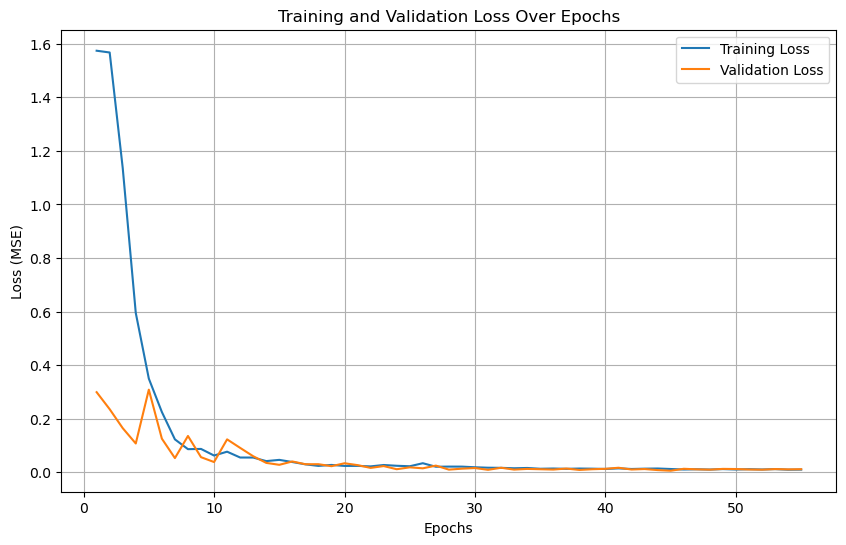

In [101]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
